# **1. Project Overview & Objective**

The  goal of our work is to design an **AI-driven Compliance Analytics System** that helps the company in:

1. Detecting **the departments that are most at risk** of compliance problems
2. Understanding **why** these risks arises  
3. Provide useful information and **data-driven** insights to aid in prevention and oversight.

To achieve this, we decided to develop two models:

To achieve this, we build a Compliance Radar (Classification Model), a predictive model that assigns each department a binary label:

- **1 = At Risk**
- **0 = Not at Risk**

This will help to identify departments that need help based on operations, culture, management, and audit issues.

---

## **Dataset Context**

The dataset contains department-level information, including:

- **Operational indicators**  
- **Cultural and governance metrics**  
- **Audit results over time**  
- **Historical violations and incidents**  
- **Department attributes** (size, division, type, etc.)

In our project, we designate this as high-risk and use it to create the target variable `is_at_risk`.

---

## **Project Flow**

This notebook follows a structured analytical pipeline:

1. **Data understanding**  
2. **Construction of the risk label (`is_at_risk`)**  
3. **Statistical analysis of high-risk vs non-risk departments**  
4. **Exploration of missingness patterns and data quality**  
5. **Correlation structure and feature relationships**  
6. **Summary of insights to guide modeling**  
7. **Compliance Radar** classification model (model building and evaluation)

This structure ensures that the modeling is grounded in a rigorous understanding of **how risk manifests statistically within the organization**, and that the final models are interpretable, robust, and aligned with internal compliance objectives.

## **1 Setup: libraries and options**

First, we will introduce the primary Python libraries that are needed in the whole process of analysis and modeling:

- `pandas` and `numpy` for data processing  
- `matplotlib` / `seaborn` for graphics  
- `scikit-learn` for data preprocessing, modeling, and evaluation  
- `sqlite3` (or SQLAlchemy) to establish a connection with the compliance database  

In addition, we have set some display options that will facilitate the reading of tables and outputs.

In [490]:

# Core / Utilities

from pathlib import Path
import sqlite3 as sq
import re
import warnings
import pickle as pk


# Data manipulation & numerical

import numpy as np
import pandas as pd


# Visualization

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns


# Stats / distributions

from scipy.stats import randint, uniform


# Scikit-learn: model selection

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_predict,
)


# Scikit-learn: preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


# Scikit-learn: models

from sklearn.linear_model import LogisticRegression


# Scikit-learn: metrics

from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    precision_score,
    recall_score,
    f1_score,
)

# XGBoost

from xgboost import XGBClassifier


# Explainability

import shap


# Global settings 

warnings.filterwarnings("once")
sns.set_style("whitegrid")  


## **2.1 Data Loading & Database Exploration**

This section initializes the project paths and performs a first exploration of the dataset stored as a SQLite database.

- **Project structure setup:** it sets `PROJECT_DIR` as the current working directory and defines two expected subfolders:
  - `data/` for input files
  - `figures/` for outputs (plots, images)

- **Data availability check:** it lists the files contained in `data/` and prints:
  - the project directory path
  - whether the `data/` and `figures/` folders exist
  - the detected dataset files

- **SQLite database discovery:** it searches inside `data/` for a file whose name starts with `org_compliance_data` and stops execution if no matching file is found.

- **Database inspection:** it opens a connection to the SQLite database, queries the database metadata (`sqlite_master`), and prints all available table names, then safely closes the connection.

- **Table loading helper:** it defines `read_db(file_path, table)`, a utility function that reads an entire table from the SQLite database into a Pandas DataFrame via `pd.read_sql_query`.

- **DataFrames creation:** it loads the main tables used in the analysis into memory:
  - `departments`
  - `risk_summary_by_division`
  - `high_risk_departments`
  - `data_dictionary`

At the end of this block, the dataset is validated, the database structure is known, and the core tables are available as DataFrames for further analysis and modeling.


In [491]:
print('cwd:', Path.cwd())

PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR/'data'
FIGURE_DIR = PROJECT_DIR/'figures'
files = [file.name for file in DATA_DIR.glob('*')]

print(f'Project directoy:{PROJECT_DIR}')
print(f'Data directory exist?:{DATA_DIR.exists()}')
print(f'Figure directory exist?:{FIGURE_DIR.exists()}')
print(f'Dataset:{files}')

org_compliance_db_file = next((file for file in DATA_DIR.glob('org_compliance_data*')),None)
assert org_compliance_db_file is not None, 'File not found'


cwd: c:\Users\morio\OneDrive\Desktop\Compliance_radar
Project directoy:c:\Users\morio\OneDrive\Desktop\Compliance_radar
Data directory exist?:True
Figure directory exist?:True
Dataset:['org_compliance_data.db']


In [492]:
conn = sq.connect(org_compliance_db_file)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print(f"Tables found in '{org_compliance_db_file}'")
if not tables:
  print("No tables were found in this database file.")
else:
  for table in tables:
    print(table[0])
if 'conn' in locals():
  conn.close()

Tables found in 'c:\Users\morio\OneDrive\Desktop\Compliance_radar\data\org_compliance_data.db'
departments
risk_summary_by_division
high_risk_departments
data_dictionary


In [493]:
def read_db(file_path,table):
  conn = sq.connect(file_path)
  df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
  return df

departments = read_db(org_compliance_db_file,'departments')
summary = read_db(org_compliance_db_file,'risk_summary_by_division')
high_risk = read_db(org_compliance_db_file,'high_risk_departments')
dictionary = read_db(org_compliance_db_file,'data_dictionary')

## **2.2 First sanity checks**

Basic checks are done on the loaded table before further processing:

- `shape`: the count of rows (departments) and columns (features)  
- `dtypes` / `.info()`: data types and missing values  
- `head()`: visual inspection of the first few rows to make sure that the data was loaded correctly

These checks give us the following confirmations:
- that the dataset is full (no unexpected empty tables),  
- that the column names are clear and significant,  
- that there are no apparent problems before starting the EDA.

### dictionary dataframe:


In [494]:
# Basic info about the data dictionary
print(dictionary.shape)
print(dictionary.columns.tolist(),'\n')


cols = dictionary.columns.tolist()

name_candidates = [c for c in cols if re.search("name|feature|column|variable", c, re.I)]
desc_candidates = [c for c in cols if re.search("desc|description|label", c, re.I)]

print("Possible columns for feature names:", name_candidates)
print("Possible columns for descriptions:", desc_candidates)


(39, 4)
['table_name', 'field_name', 'data_type', 'description'] 

Possible columns for feature names: ['table_name', 'field_name']
Possible columns for descriptions: ['description']


In [495]:

feature_name = "field_name"
description = "description"


dictionary_display = (dictionary[['table_name',feature_name, description, 'data_type']].rename(columns={feature_name: "Feature",description: "Description"}).sort_values("Feature").reset_index(drop=True))

pd.set_option("display.max_rows", None)        # show all rows
pd.set_option("display.max_colwidth", 200)     # max characters per cell in Description
pd.set_option("display.width", None)           # use full available width


display(dictionary_display)


,table_name,Feature,Description,data_type
0,_metadata,academic_year,2025-2026,string
1,departments,audit_score_q1,First quarter audit score (0-100),float
2,departments,audit_score_q2,Second quarter audit score (0-100),float
3,departments,compliance_score_final,Final annual compliance score (0-100) - PRIMARY TARGET,float
4,departments,creation_reason,"Reason for department creation (Merger, Expansion, Regulation, Restructuring, Innovation)",string
5,departments,dept_age_years,Age of department in years since establishment,integer
6,departments,dept_category,"Primary compliance category (Financial_Reporting, Operational_Compliance, Risk_Management)",string
7,departments,dept_id,Unique department identifier,string
8,departments,dept_name,Department name,string
9,departments,dept_type,"Department type (Operations, Support, Compliance, Finance, Technology, Legal)",string


### summary dataframe

In [496]:
summary.info()
summary.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   division              2 non-null      object 
 1   avg_compliance_score  2 non-null      float64
 2   std_compliance_score  2 non-null      float64
 3   min_compliance_score  2 non-null      float64
 4   max_compliance_score  2 non-null      float64
 5   total_violations      2 non-null      float64
 6   avg_risk_score        2 non-null      float64
 7   dept_count            2 non-null      int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 260.0+ bytes


,division,avg_compliance_score,std_compliance_score,min_compliance_score,max_compliance_score,total_violations,avg_risk_score,dept_count
0,Corporate_HQ,63.245477,13.369017,0.0,95.0,122.0,24.463636,428
1,Regional_Operations,76.054167,13.777896,50.8,100.0,55.0,64.000000,27


We can see that the `summary` DataFrame contains statistics about the compliance score for two department types:

- **`Corporate_HQ`**: Has a lower average compliance score, and there are many more departments in this group.  
- **`Regional_Operations`**: Has a higher average compliance score, but there are far fewer departments in this group.


### departments dataframe:

In [497]:

departments.info()
departments.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dept_id                          709 non-null    object 
 1   dept_name                        709 non-null    object 
 2   dept_category                    709 non-null    object 
 3   division                         455 non-null    object 
 4   dept_type                        413 non-null    object 
 5   dept_age_years                   411 non-null    float64
 6   location_type                    410 non-null    object 
 7   team_size                        409 non-null    object 
 8   reporting_structure              413 non-null    object 
 9   manager_experience_level         413 non-null    float64
 10  supervisor_experience_level      409 non-null    float64
 11  primary_function                 416 non-null    object 
 12  secondary_function    

,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1620,Core Compliance,Financial_Reporting,Corporate_HQ,Operations,8.0,Remote,Large,Centralized,2.0,...,2.0,3.0,1.0,NaN,5.0,NaN,55.0,55.0,65.0,12.0
1,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,NaN,2.0,2.0,1.0,26.0,NaN,40.0,NaN,43.0
2,DEPT-4917,Central Hub,Operational_Compliance,None,None,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEPT-6959,Compliance - Legacy Region,Financial_Reporting,Corporate_HQ,Support,8.0,Urban,Large,Centralized,4.0,...,3.0,4.0,1.0,1.0,5.0,2.0,70.0,75.0,85.0,11.0
4,DEPT-4312,West Internal Controls,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,1.0,...,4.0,2.0,1.0,1.0,5.0,2.0,45.0,45.0,45.0,11.0


The **`departments`** DataFrame is the main dataset for this project. It contains all the information about the departments described in the **`data_dictionary`**.

- **1 row = 1 department**


### high_risk dataframe

In [498]:
high_risk.info()
high_risk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dept_id                          201 non-null    object 
 1   dept_name                        201 non-null    object 
 2   dept_category                    201 non-null    object 
 3   division                         201 non-null    object 
 4   dept_type                        180 non-null    object 
 5   dept_age_years                   173 non-null    float64
 6   location_type                    180 non-null    object 
 7   team_size                        179 non-null    object 
 8   reporting_structure              181 non-null    object 
 9   manager_experience_level         180 non-null    float64
 10  supervisor_experience_level      181 non-null    float64
 11  primary_function                 185 non-null    object 
 12  secondary_function    

,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,NaN,2.0,2.0,1.0,26.0,NaN,40.0,NaN,43.0
1,DEPT-4312,West Internal Controls,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,1.0,...,4.0,2.0,1.0,1.0,5.0,2.0,45.0,45.0,45.0,11.0
2,DEPT-3347,Business Integrity - Central Region,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,2.0,...,4.0,4.0,3.0,5.0,5.0,6.0,45.0,50.0,50.0,53.0
3,DEPT-2554,Central Team,Financial_Reporting,Corporate_HQ,Support,5.0,Urban,Small,Autonomous,3.0,...,3.0,4.0,4.0,4.0,1.0,0.0,65.0,60.0,65.0,40.0
4,DEPT-3151,Compliance - East Region,Financial_Reporting,Corporate_HQ,None,8.0,Urban,Small,Centralized,3.0,...,2.0,4.0,NaN,4.0,4.0,10.0,50.0,50.0,50.0,35.0


The **`high_risk`** DataFrame appears to be a filtered subset of the `departments` dataset and, as the name suggests, contains departments labeled as **high risk**.

- **1 row = 1 department**


# 2.3 Null count analysis

One of the things that caught our attention when we ran `departments.info()` is the presence of some columns with a peculiar pattern in their non-null counts, where a significant proportion of the values were missing.

To clear this up, we performed a more thorough investigation of the problem. For every feature we calculated:

- the total number of missing values (`null_count`)
- the percentage of missing values of all the departments (`null_percent`)

The table that follows gives a summary of this information and also helps us to assess the total data quality before the analysis.

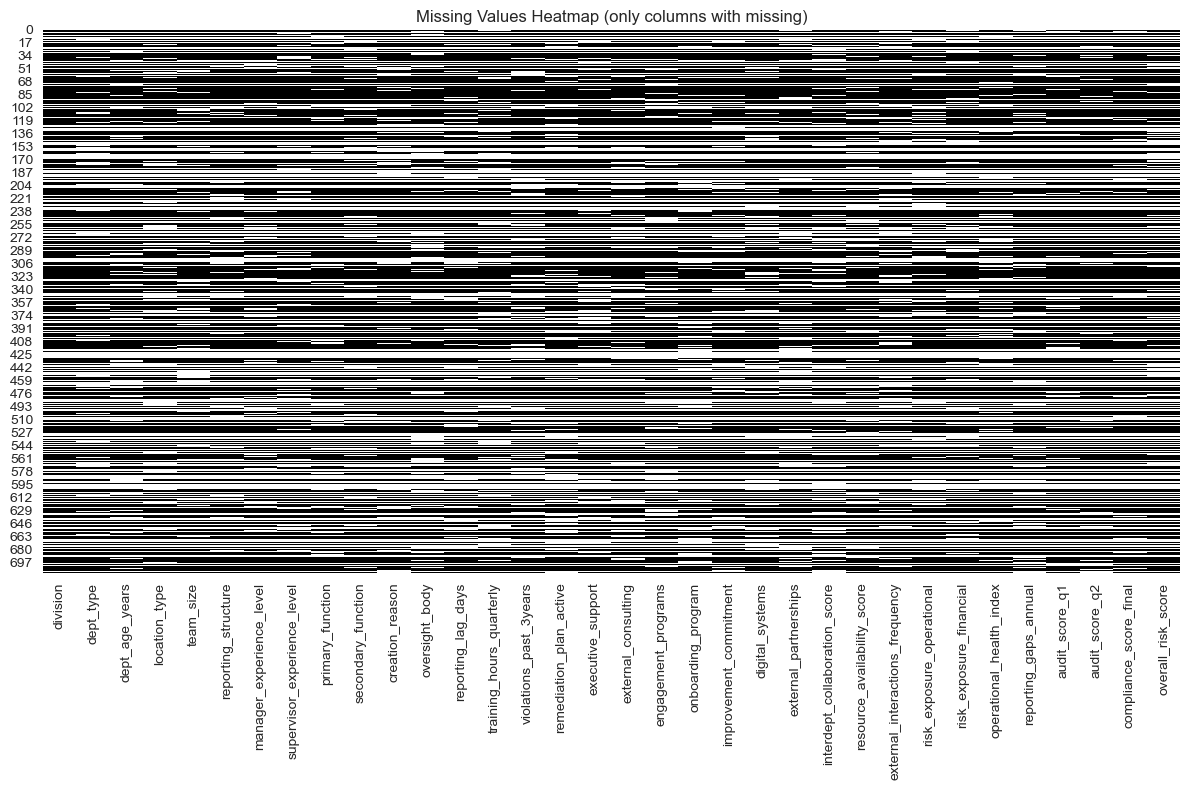

In [499]:

missing_values = departments.isnull().sum()
missing_values = missing_values[missing_values > 0]

if missing_values.empty:
    print("No missing values found.")
else:
    missing_percentage = (missing_values / len(departments)) * 100
    missing_df = (
        pd.DataFrame({
            "missing_count": missing_values,
            "missing_%": missing_percentage
        })
        .sort_values("missing_%", ascending=False)
    )

    # Heatmap only for columns with missing values
    cols_with_missing = missing_values.index

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        departments[cols_with_missing].isnull(),
        cbar=False,
        cmap="gray"
    )
    plt.title("Missing Values Heatmap (only columns with missing)")
    plt.tight_layout()
    plt.savefig(FIGURE_DIR / "missing_values_heatmap_only_missing_cols.png",
                bbox_inches="tight", dpi=300)
    plt.show()


In [500]:
missing_df

,missing_count,missing_%
digital_systems,304,42.877292
interdept_collaboration_score,303,42.736248
violations_past_3years,303,42.736248
oversight_body,303,42.736248
external_interactions_frequency,303,42.736248
onboarding_program,302,42.595205
overall_risk_score,300,42.313117
training_hours_quarterly,300,42.313117
external_partnerships,300,42.313117
team_size,300,42.313117


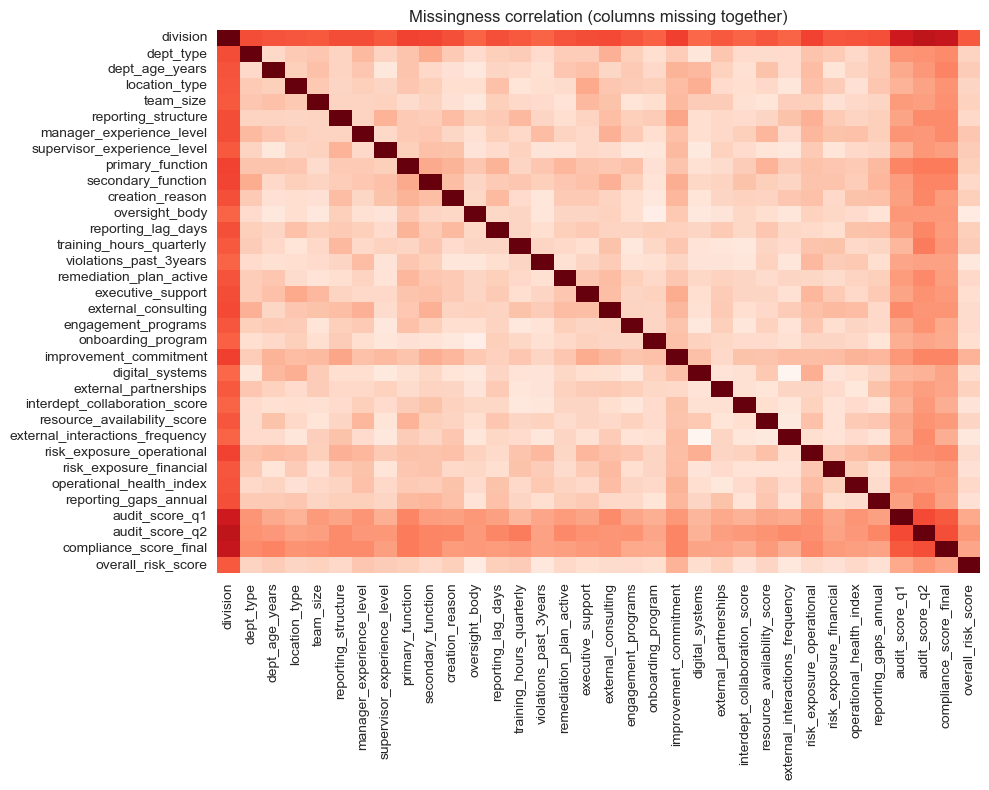

In [501]:
miss = departments[cols_with_missing].isna().astype(int)
miss_corr = miss.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(miss_corr, cmap="Reds", cbar=False)
plt.title("Missingness correlation (columns missing together)")
plt.tight_layout()
plt.savefig(FIGURE_DIR / "missingness_correlation_heatmap.png",
                bbox_inches="tight", dpi=300)
plt.show()


In [502]:
cols = cols_with_missing
miss_rate_by_type = departments[cols].isna().groupby(departments["dept_type"]).mean() * 100
miss_rate_by_type.T.sort_values(by=miss_rate_by_type.index[0], ascending=False).head(20)


dept_type,Compliance,Finance,Legal,Operations,Support,Technology
oversight_body,36.363636,28.571429,7.142857,12.666667,8.252427,0.000000
external_interactions_frequency,27.272727,14.285714,14.285714,8.000000,11.650485,11.111111
engagement_programs,27.272727,14.285714,7.142857,8.000000,10.194175,11.111111
audit_score_q1,27.272727,0.000000,14.285714,4.666667,4.368932,5.555556
primary_function,18.181818,14.285714,14.285714,8.000000,8.252427,5.555556
remediation_plan_active,18.181818,7.142857,0.000000,8.666667,11.165049,5.555556
risk_exposure_financial,18.181818,7.142857,7.142857,14.000000,6.310680,11.111111
external_partnerships,18.181818,7.142857,7.142857,10.666667,8.737864,11.111111
supervisor_experience_level,18.181818,0.000000,21.428571,11.333333,9.223301,5.555556
reporting_structure,18.181818,7.142857,7.142857,11.333333,8.737864,5.555556


In [503]:
miss = departments[cols_with_missing].isna().astype(int)
corr = miss.corr()

# keep only upper triangle (no diagonal) -> removes mirrored pairs
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)

pairs = (
    corr.where(mask)
        .stack()
        .sort_values(ascending=False)
)

pairs.head(15)


division        audit_score_q2               0.941414
                compliance_score_final       0.935838
                audit_score_q1               0.927563
                improvement_commitment       0.892869
                risk_exposure_operational    0.890275
                primary_function             0.890275
                secondary_function           0.887690
                external_consulting          0.885116
audit_score_q1  audit_score_q2               0.884492
division        dept_type                    0.882552
                reporting_structure          0.882552
                manager_experience_level     0.882552
                executive_support            0.882552
audit_score_q2  compliance_score_final       0.881206
division        reporting_lag_days           0.879998
dtype: float64

In [504]:
cols = cols_with_missing
miss_rate_by_type = departments[cols].isna().mean(axis=1).groupby(departments["dept_type"]).mean() * 100
miss_rate_by_type.sort_values(ascending=False)


dept_type
Legal         11.344538
Finance       10.504202
Compliance     9.893048
Operations     8.862745
Support        8.566533
Technology     6.862745
dtype: float64

## Missing values and target selection

The missing-value summary shows that a large portion of the feature set is incomplete. Many operational, risk, and audit-related variables exhibit **~41–43%** missingness (e.g., `digital_systems`, `interdept_collaboration_score`, `violations_past_3years`, `overall_risk_score`, and several governance/operations indicators). In addition, the “outcome-style” variables are also affected: `audit_score_q1` is missing for **~39.35%**, `audit_score_q2` for **~38.65%**, and `compliance_score_final` for **~38.93%** of departments.

Beyond the overall rates, missingness is **structured rather than random**. The missingness-correlation analysis highlights a tight block of variables that tend to be absent together. For example, missingness in `division` is very strongly aligned with missingness in the audit and compliance outcomes (`audit_score_q2`: **0.94**, `compliance_score_final`: **0.94**, `audit_score_q1`: **0.93**) and with several operational/risk fields (e.g., `improvement_commitment`, `risk_exposure_operational`, `primary_function`, `secondary_function`, `external_consulting`, all **~0.89**). This suggests that, for a subset of departments, an entire “module” of audit/risk information is not recorded, rather than values being missing sporadically.

Missingness also varies by department type. The average row-level missing rate (computed over the columns with missing values) is highest for **Legal (~11.34%)** and **Finance (~10.50%)**, and lowest for **Technology (~6.86%)**. Individual features show large group differences as well (e.g., `oversight_body` missingness ranges from **36.36%** in Compliance to **0%** in Technology).

In the data dictionary, `compliance_score_final` is identified as the main compliance outcome. Nevertheless, this column is absent for around **39%** of the departments in the real dataset. From the very first moment of the analysis, this issue poses a practical modeling question:

- If we were to directly regress on `compliance_score_final`, it would require very strong—and likely fragile—assumptions to impute a heavily missing outcome.
- The binary `is_at_risk` flag permits us to define a properly framed prediction problem for **all** departments, without making arbitrary target imputations.

Thus, throughout the remainder of the project, we will consider **`is_at_risk`** as our principal supervised learning target, while `compliance_score_final` will only serve as an auxiliary signal for interpretation and sanity checks rather than being the variable to be predicted.


# **3. Creating the Target Variable (`is_at_risk`)**

### 3.1 Distribution of At-Risk vs Not-at-Risk Departments
We now construct the binary target variable for the Compliance Radar.

Every department is marked as:

- **1 = At Risk**: if its `dept_id` appears in the high-risk list  
- **0 = Not at Risk**: otherwise  

This target will be used in the classification models developed later in the notebook.

In [505]:
# Identify high-risk department IDs
high_risk_ids = set(high_risk['dept_id'])
print(len(high_risk_ids))


# Remove duplicate department rows (if any)
print(f"Total rows: {len(departments)}")
departments = departments.drop_duplicates(subset=['dept_id'], keep='first')
print(f"rows after cleaning: {len(departments)}")

# Recreate the target variable after cleaning
departments['is_at_risk'] = departments['dept_id'].apply(lambda x: 1 if x in high_risk_ids else 0)
print(f"Target count finale: {departments['is_at_risk'].sum()}")

departments['is_at_risk'].value_counts()



200
Total rows: 709
rows after cleaning: 682
Target count finale: 200


is_at_risk
0    482
1    200
Name: count, dtype: int64


From the output above, we can see that approximately **30%** of the departments are
classified as **“at risk”**, while the remaining **70%** are classified as **“not at risk”**.

This tells us that:

- the dataset is **imbalanced**, but the minority class remains sufficiently substantial for significant modeling
- the Compliance Radar must be careful when finding this minority class, because missing a department that could be at risk may cause problems with operations and rules.

This situation shows how compliance usually works: most departments are not seen as problematic, but a good number need closer attention.

### 3.2 Risk Distribution by Division

In [506]:
risk_by_div = (departments.groupby('division')['is_at_risk'].agg(['count', 'sum', 'mean']).rename(columns={'count': 'dept_count','sum': 'n_at_risk','mean': 'risk_rate'}))

print(risk_by_div)

                     dept_count  n_at_risk  risk_rate
division                                             
Corporate_HQ                411        175   0.425791
Regional_Operations          27         23   0.851852




The table above illustrates the distribution of compliance risk across the organization's divisions. For each section, we present:

- (`dept_count`): **total number of departments**

- (`n_at_risk`):  **number of departments at risk**

- (`risk_rate`): **percentage of departments at risk**

This analysis helps to recognize **structural variations** in risk across divisions.

- Divisions with a **high level of risk** may face more complex operations, insufficient governance practices, or more frequent audit issues.

- Divisions with a **low risk rate** may have stronger internal controls or better-developed processes.

This information allows the organization to focus on training, auditing, and monitoring in areas with structurally high risk.

### 3.3 Visualizing Missingness by Risk Group

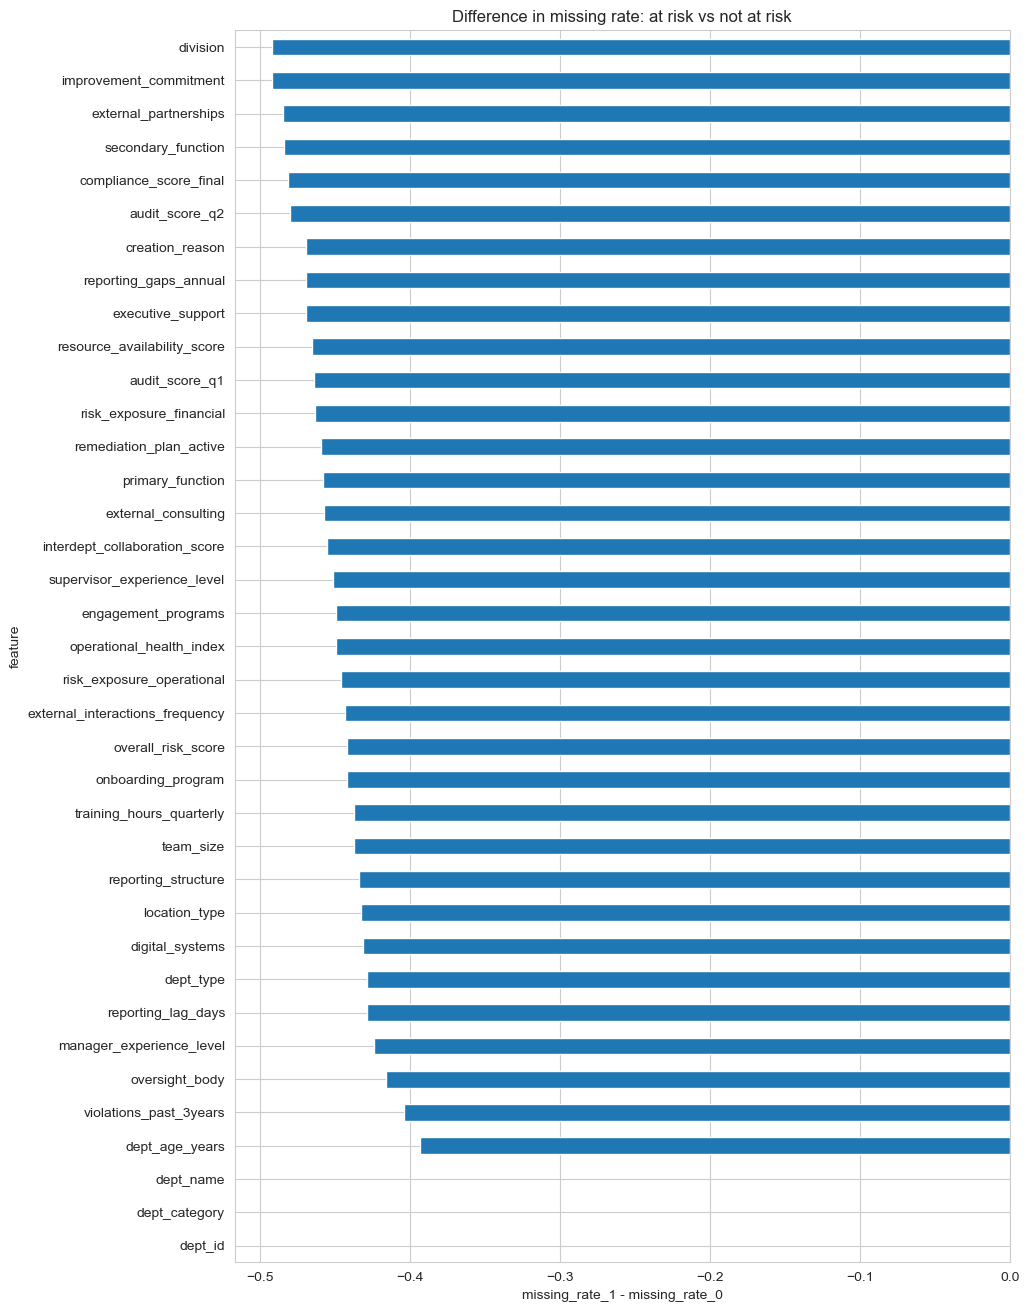

In [507]:
missing_by_risk = {}
for col in departments.columns:
    if col not in ['is_at_risk']:
        missing_rate_0 = departments[departments.is_at_risk == 0][col].isna().mean()
        missing_rate_1 = departments[departments.is_at_risk == 1][col].isna().mean()
        missing_by_risk[col] = [missing_rate_0, missing_rate_1]

missing_by_risk = pd.DataFrame(missing_by_risk, index=['missing_rate_not_risk', 'missing_rate_risk']).T
missing_by_risk['diff'] = missing_by_risk['missing_rate_risk'] - missing_by_risk['missing_rate_not_risk']
missing_by_risk_sorted = missing_by_risk.sort_values('diff', ascending=False)

plt.figure(figsize=(10, 16))
missing_by_risk_sorted['diff'].plot(kind='barh')
plt.title("Difference in missing rate: at risk vs not at risk")
plt.xlabel("missing_rate_1 - missing_rate_0")
plt.ylabel("feature")
plt.savefig(FIGURE_DIR / "difference_in_missing_rate_bar_plot.png",
                bbox_inches="tight", dpi=300)
plt.show()



The bar chart above shows, for each feature, the difference in missing-value rates between at-risk and not-at-risk departments:


**Interpretation:**

- Negative values: the characteristic is generally more deficient in departments NOT AT RISK

- Positive values: the functionality is generally more deficient in departments AT RISK

Departments at risk have a significantly lower percentage of missing values (≈10-15%) than departments not at risk (≈50-55%) for almost all variables.

This pattern is counterintuitive but significant:

- High-risk departments have fewer missing values, indicating that they perform more accurate monitoring, frequent checks, and stricter reporting methods.


- Non-risk departments have huge gaps in their data, implying less accurate monitoring, weaker reporting discipline, or an unclear structure.

# 4. Descriptive Statistics & Feature Relationships

### 4.1 Numerical Features by Risk Group (mean & median)

Departments at risk (`is_at_risk = 1`) and those not at risk (`is_at_risk = 0`) are now compared using numerical characteristics.

For each variable, the table shows:

- the **mean** value in the two groups
- the **median** value in the two groups

This allows us to determine if departments at risk have higher or lower values for important metrics such as audit scores, reporting gaps, violations, and risk exposure.


In [508]:
# Select numerical columns (excluding the target)
numeric_cols = departments.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col not in ['is_at_risk']]

# Mean and median by risk group
stats_by_risk = departments.groupby('is_at_risk')[numeric_cols].agg(['mean', 'median'])


### 4.2 Mean Differences (Δ mean)

To better highlight contrasts between the two groups, we compute:

Δ = mean(at risk) - mean(not at risk)

- **Positive Δ**: the feature tends to be **higher** in at-risk departments  
- **Negative Δ**: the feature tends to be **lower** in at-risk departments

In [509]:
# Mean by risk group (transpose so features are rows)
mean_stats = departments.groupby('is_at_risk')[numeric_cols].mean().T
mean_stats['delta'] = mean_stats[1] - mean_stats[0]
mean_stats_sorted = mean_stats.sort_values('delta', ascending=True)

mean_stats_sorted

is_at_risk,0,1,delta
compliance_score_final,70.730088,56.224737,-14.505352
audit_score_q2,67.617467,56.046597,-11.570870
audit_score_q1,66.701322,56.191979,-10.509343
training_hours_quarterly,45.092593,41.022599,-4.069994
manager_experience_level,2.840909,2.352273,-0.488636
supervisor_experience_level,2.588785,2.184358,-0.404428
improvement_commitment,0.958333,0.755319,-0.203014
onboarding_program,0.819444,0.668539,-0.150905
interdept_collaboration_score,3.863208,3.720670,-0.142537
operational_health_index,3.558140,3.418994,-0.139145


### 4.3 Visualizing Δ Mean
Each bar in the chart above indicates:
- **Positive values**: the characteristic is **higher** in departments at risk

    (e.g., `overall_risk_score`, `reporting_gaps_annual`, `violations_past_3years`, and `risk_exposure_indicators`)

- **Negative values**: the characteristic is **lower** in departments at risk

    *(e.g.`compliance_score_final`, `audit_score_q1`, `audit_score_q2`, and `training_hours_quarterly` ).*

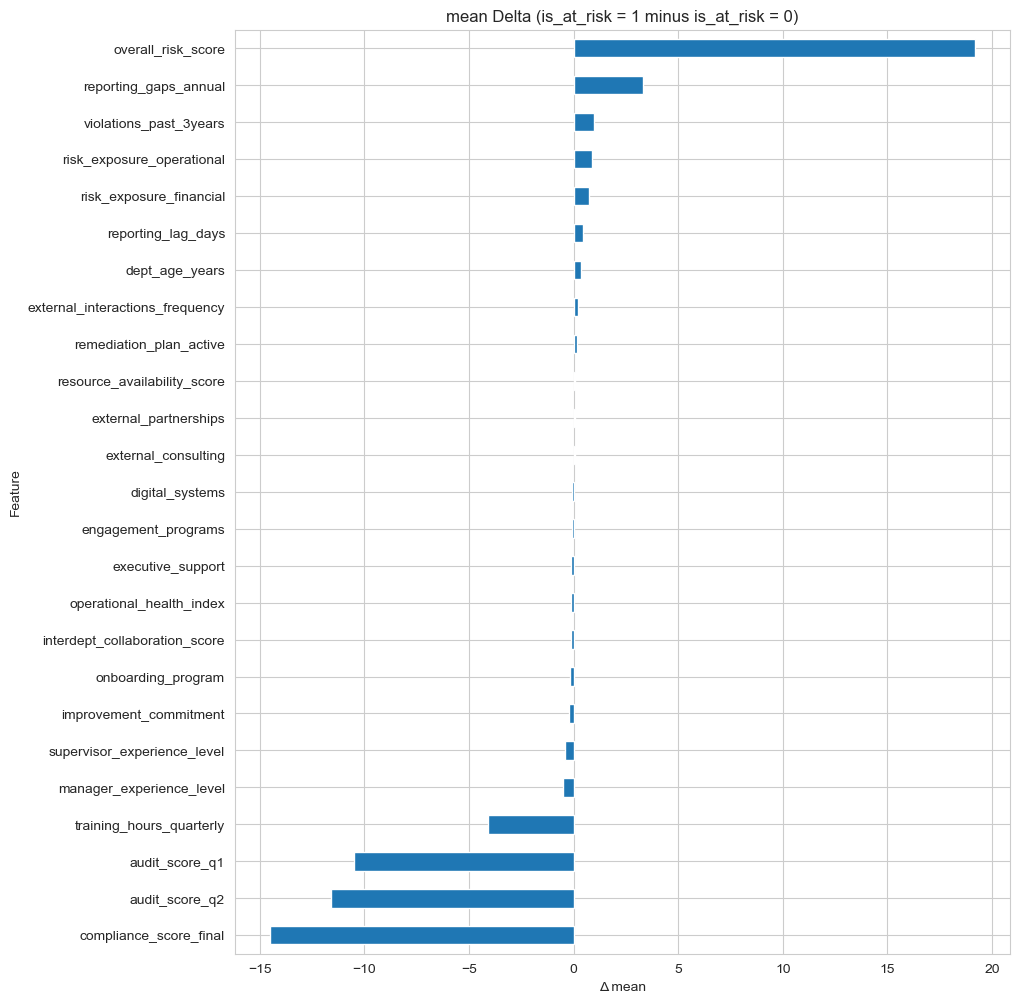

In [510]:
plt.figure(figsize=(10, 12))
mean_stats_sorted['delta'].plot(kind='barh')
plt.title("mean Delta (is_at_risk = 1 minus is_at_risk = 0)")
plt.xlabel("Δ mean")
plt.ylabel("Feature")
plt.savefig(FIGURE_DIR/'mean_delta_bar_plot.png',bbox_inches='tight',dpi=300)
plt.show()

**Interpreting graph**

- `overall_risk_score`: about +19 points higher
- `reporting_gaps_annual`: around +3 more gaps
- `violations_past_3years`: roughly +1 more violation
- `audit & compliance scores:` 10–15 points lower on average

Overall, this shows a consistent pattern: departments at risk combine **worse audit/compliance scores** with **higher operational risk, more violations, and more reporting gaps**, which is exactly what we would expect from a genuine risk label.

### 4.4 Top 10 Risk Drivers and Risk Buffers

We now extract the top features where Δ mean is:

- **most positive**: potential **risk drivers**  
- **most negative**: potential **protective factors (buffers)**

In [511]:
print('delta: at_risk - not_at_risk')
delta = mean_stats_sorted['delta']

# Top 10 largest positive Δ (higher in at-risk departments)
top_positive = delta.sort_values(ascending=False).head(10)
# Top 10 most negative Δ (lower in at-risk departments)
top_negative = delta.sort_values(ascending=True).head(10)

print("Top 10 positive delta(risk drivers):\n")
print(top_positive)

print('Top 10 negative delta(risk buffers):\n')
print(top_negative)

delta: at_risk - not_at_risk
Top 10 positive delta(risk drivers):

overall_risk_score                 19.167889
reporting_gaps_annual               3.299428
violations_past_3years              0.977273
risk_exposure_operational           0.864916
risk_exposure_financial             0.723212
reporting_lag_days                  0.445840
dept_age_years                      0.368217
external_interactions_frequency     0.218429
remediation_plan_active             0.152692
resource_availability_score         0.086626
Name: delta, dtype: float64
Top 10 negative delta(risk buffers):

compliance_score_final          -14.505352
audit_score_q2                  -11.570870
audit_score_q1                  -10.509343
training_hours_quarterly         -4.069994
manager_experience_level         -0.488636
supervisor_experience_level      -0.404428
improvement_commitment           -0.203014
onboarding_program               -0.150905
interdept_collaboration_score    -0.142537
operational_health_index      

#### Managerial definition of risk drivers and buffers (subject to missingness).

The analysis of the Δ mean presents an image of consistency of what distinguishes the at-risk departments.
to less dangerous ones, at least among those departments where the information is stored in duly recorded form.

On the side of the risk driver (greater in at-risk departments):

- The mean difference in the overall_risk_score is of the order of **+19 points**.
- the value of reporting gaps annual and the reporting lag days is greater so there is more missing and delayed reporting.
- Higher in violations past 3 years, which is an indicator of a history of compliance incidence.
- Higher risk exposure is observed in both the operational (risk exposures operational) and financial (risk exposures financial) exposure.
- The value of dept age years is greater indicating that older departments are more prone to build risk with time.

A combination of these patterns characterizes at-risk departments as the ones that integrate high structural.
risk, poor reporting hygiene and a history of previous violations.

On risk buffer side (greater in not-at-risk departments):

- The scores of compliance are significantly higher (final value of compliance score and audits score) and q1/q2 of auditing score is larger, which suggests stronger controls.
- training hours quarterly are higher which indicates more systematic and regular training.
- manager experience level and supervisor experience level are larger and this is an indication of a higher experienced leadership.
Improvement commitment, Onboarding program, interdept collaboration score and -
There are increased values in the operational health indexes, which implies the improved culture, integration and health of the operations.

In managerial perspective, this means that:

- High-risk departments are not necessarily unlucky: they are placed at the crossroads of **high exposure**,
poor reporting and accrued problems.
- Departments with a high degree of safety are defined by the good scores on audits and compliance, ongoing training.
work and an improvement-focused leadership.

Nonetheless, such learnings need to be viewed through the prism of the so-called missing data trend:

- The above features (mostly audit and compliance scores, training metrics, etc.) are many.
**not registered to all the departments**.
- More specifically, safer departments tend to be missing more values on some of these metrics,
as they are not so strictly monitored.

Consequently, the Δ mean patterns explain variations between departments where the information is available.
is not in fact the whole population of departments, but is usually only a fraction of it.
The fact that such measures do not always occur in the departments is itself the process of the surveillance bias mechanism.
that we more explicitly examine in the succeeding passages.

# 5. Correlation structure and relationships between characteristics

In this section, we analyze how numerical variables are correlated with each other and with the target variable is_at_risk.

The following aspects can be analyzed using correlation analysis:
- groups of variables that move together
- duplicate information (highly correlated characteristics)
- probable risk factors protective factors linked to low risk

In [512]:
numeric_cols = departments.select_dtypes(include = ['float64', 'int64']).columns.tolist()


### 5.2 Correlation Matrix (All Numerical Variables)

We compute correlations across all numerical variables to identify structural relationships and potential redundancy.

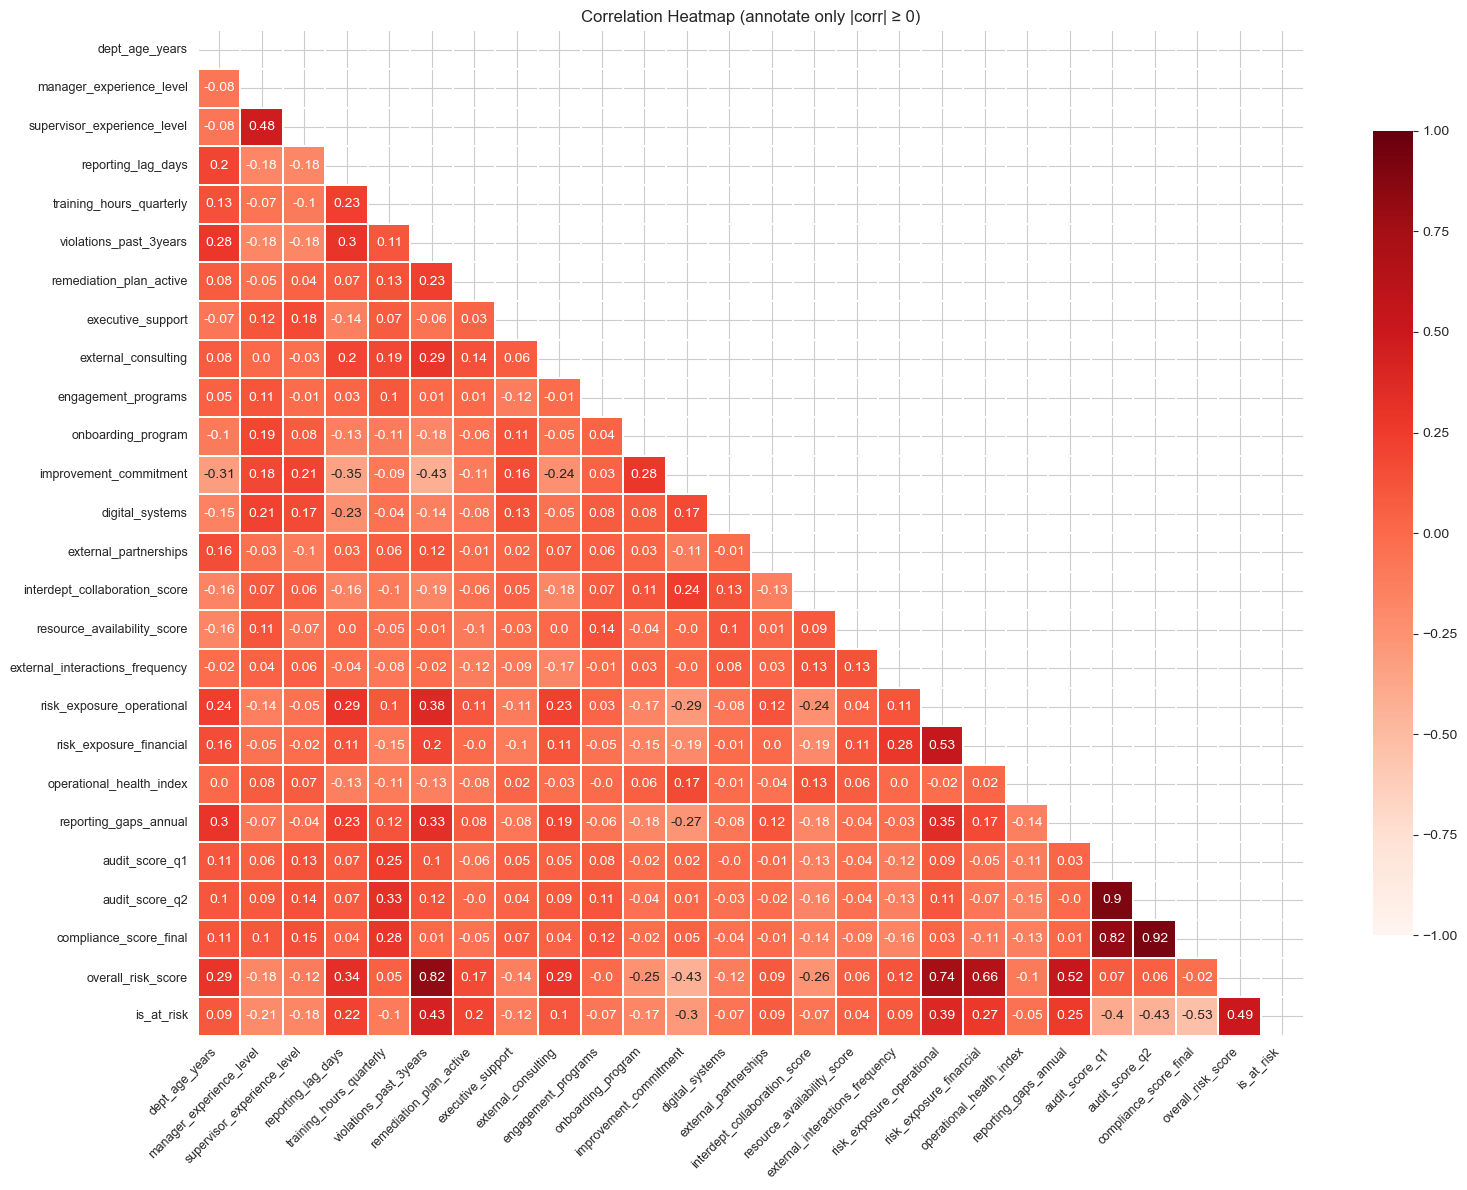

In [513]:
corr = departments[numeric_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

annot_mat = corr.round(2)

plt.figure(figsize=(16, 12))
ax = sns.heatmap(
    corr,
    mask=mask,
    cmap="Reds",
    vmin=-1, vmax=1, center=0,
    linewidths=0.3,
    cbar_kws={"shrink": 0.8},
    annot=annot_mat,
    fmt=""
)
ax.set_title(f"Correlation Heatmap (annotate only |corr| ≥ {TH})")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(FIGURE_DIR/f"feature_correlation_heatmap_annot_{TH}.png", dpi=300, bbox_inches="tight")
plt.show()


In [514]:
corr_no_diag = corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype = bool))

strong_corr = (corr_no_diag.unstack().dropna().sort_values(ascending = False))

strong_corr.head(20)

audit_score_q2               compliance_score_final         0.921045
compliance_score_final       audit_score_q2                 0.921045
audit_score_q1               audit_score_q2                 0.899775
audit_score_q2               audit_score_q1                 0.899775
audit_score_q1               compliance_score_final         0.822933
compliance_score_final       audit_score_q1                 0.822933
violations_past_3years       overall_risk_score             0.822233
overall_risk_score           violations_past_3years         0.822233
                             risk_exposure_operational      0.742640
risk_exposure_operational    overall_risk_score             0.742640
overall_risk_score           risk_exposure_financial        0.656848
risk_exposure_financial      overall_risk_score             0.656848
                             risk_exposure_operational      0.534551
risk_exposure_operational    risk_exposure_financial        0.534551
reporting_gaps_annual        overa

Key Insights from the table:

- Audit performance variables were strongly correlated **(ρ≈0.90)**, indicating consistency in internal control quality.

- Operational and financial risk exposures formed a tightly connected cluster **(ρ≈0.55)**, together with past violations and reporting delays.

- Leadership experience variables showed moderate correlation **(ρ≈0.48)**, suggesting that managerial maturity is a systematic attribute.

- Reporting gaps and violations were strongly associated **(ρ≈0.33)**, confirming that weak reporting practices often co-occur with higher operational risk and historical non-compliance.

Overall, these clusters represent coherent behavioral patterns that align closely with the risk classification, reinforcing the validity of the dataset and guiding feature engineering for the predictive model.

### 5.5 Correlation With the Target Variable (is_at_risk)

We now examine how each numerical feature correlates specifically with the risk label.

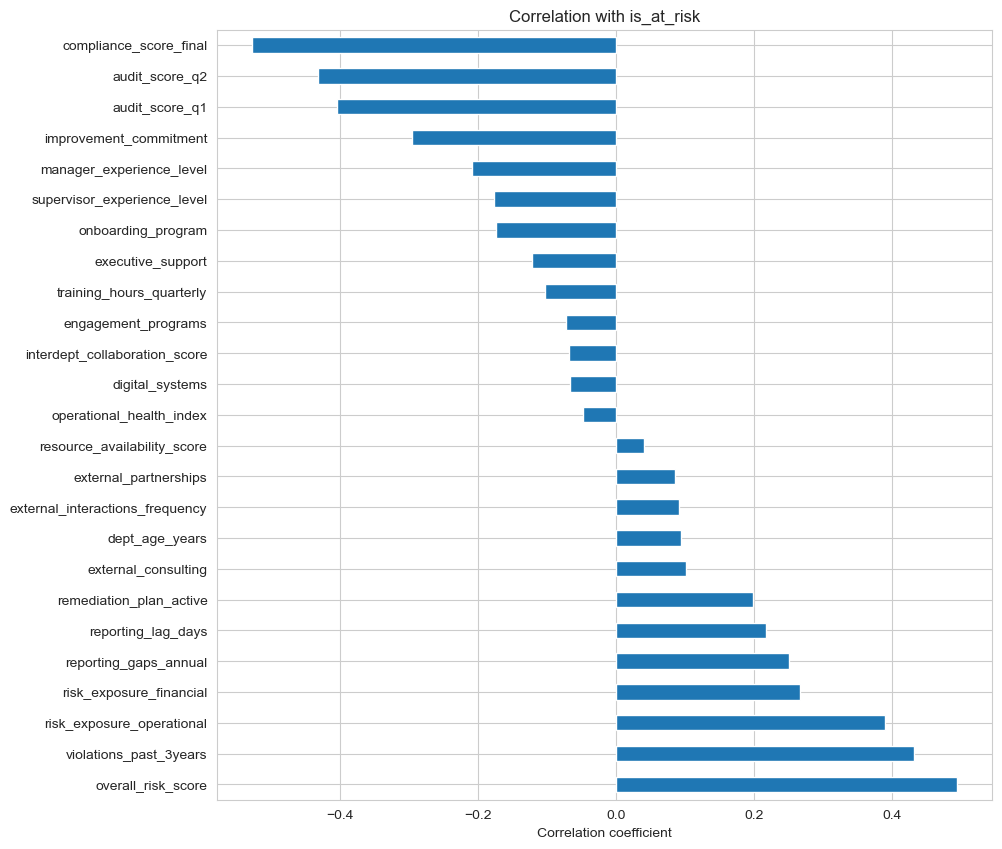

In [515]:
numeric_cols=departments.select_dtypes(include = ['float64', 'int64']).columns.tolist()

corr_Y = departments[numeric_cols].corr()['is_at_risk'].sort_values(ascending = False)

corr_Y.drop('is_at_risk').plot(kind = 'barh', figsize = (10,10))
plt.title("Correlation with is_at_risk")
plt.xlabel("Correlation coefficient")
plt.savefig(FIGURE_DIR/'feature_correlations_with_target.png',bbox_inches='tight',dpi=300)
plt.show()

A positive correlation means that as risk goes up, the feature also goes up; a negative correlation means the feature goes down in high-risk departments.

**Key findings:**
Factors that increase risk:
- Past violations (ρ = 0.42)
- Operational risk exposure (ρ = 0.39)
- Financial risk exposure (ρ = 0.27)
- Reporting gaps (ρ = 0.25)
- Reporting delays (ρ = 0.22)
These show departments with more problems and higher risk.

**Factors that reduce risk:**
- Audit scores (ρ ≈ –0.44)
- Commitment to improvement (ρ = –0.29)
- Experience of managers and supervisors (ρ ≈ –0.18)
- Training hours (ρ = –0.12)
These show better management and healthier practices.

**Overall:**
The pattern is clear:
more problems and poor reporting lead to higher risk;strong audits and experienced leaders lead to lower risk.
This shows that the risk label matches real behavior and supports choosing these factors for the predictive model.

# 6.Analyzing Categorical Features  
In this part, we look at categorical variables (like department type, division, location, and reporting structure) to see how risk percentages differ among groups.

This helps us find:
- groups that have higher risk
- parts of the organization that do better or worse
- factors that might affect risk  

We start by choosing the categorical columns.

In [516]:
categorical_cols = departments.select_dtypes(include = 'object').columns.tolist()
categorical_cols.remove('dept_id')
categorical_cols.remove('dept_name')
print(categorical_cols)

['dept_category', 'division', 'dept_type', 'location_type', 'team_size', 'reporting_structure', 'primary_function', 'secondary_function', 'creation_reason', 'oversight_body']


In [517]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def categorical_risk_table(df, col, target="is_at_risk", missing_label="Missing",
                           min_count=10, top_n=None, sort_by="risk_%"):
    s = df[col].fillna(missing_label).astype(str)
    y = df[target]

    # Group rare categories into 'Other'
    if min_count is not None and min_count > 1:
        vc = s.value_counts(dropna=False)
        rare = vc[vc < min_count].index
        if len(rare) > 0:
            s = s.where(~s.isin(rare), other="Other")

    # Counts by category x target
    ct_counts = pd.crosstab(s, y, dropna=False)

    # Ensure both classes exist
    for cls in [0, 1]:
        if cls not in ct_counts.columns:
            ct_counts[cls] = 0
    ct_counts = ct_counts[[0, 1]]

    # Percentages by category
    ct_pct = ct_counts.div(ct_counts.sum(axis=1), axis=0) * 100
    ct_pct.columns = ["not_risk_%", "risk_%"]

    out = ct_pct.copy()
    out["count"] = ct_counts.sum(axis=1)
    out["n_not_risk"] = ct_counts[0]
    out["n_risk"] = ct_counts[1]

    # Keep only top_n by count (after grouping), if requested
    if top_n is not None:
        keep = out.sort_values("count", ascending=False).head(top_n).index
        out = out.loc[keep]

    return out.sort_values(sort_by, ascending=False)


def plot_categorical_risk(df, col, FIGURE_DIR=FIGURE_DIR, target="is_at_risk", missing_label="Missing",
                          min_count=10, top_n=20, show_counts=True, save=True, dpi=300):
    """
    Plots risk_% by category and optionally saves the figure in FIGURE_DIR.
    Returns the summary table used for plotting.
    """
    tab = categorical_risk_table(
        df, col, target=target, missing_label=missing_label,
        min_count=min_count, top_n=top_n, sort_by="risk_%"
    )

    baseline = df[target].mean() * 100

    fig_h = max(4, 0.35 * len(tab) + 1.5)
    fig, ax = plt.subplots(figsize=(10, fig_h))

    ax.barh(tab.index, tab["risk_%"])
    ax.axvline(baseline, linestyle="--", linewidth=1)

    ax.set_title(f"Risk % by {col} (Missing as category)")
    ax.set_xlabel("Risk %")
    ax.set_ylabel(col)

    # Fix Matplotlib ticklabels warning
    if show_counts:
        labels = [f"{cat} (n={int(tab.loc[cat,'count'])})" for cat in tab.index]
        ax.set_yticks(np.arange(len(tab.index)))
        ax.set_yticklabels(labels)

    plt.tight_layout()

    if save:
        filename = f"risk_by_{col}.png".lower().replace(" ", "_")
        fig.savefig(FIGURE_DIR / filename, dpi=dpi, bbox_inches="tight")

    plt.show()
    return tab


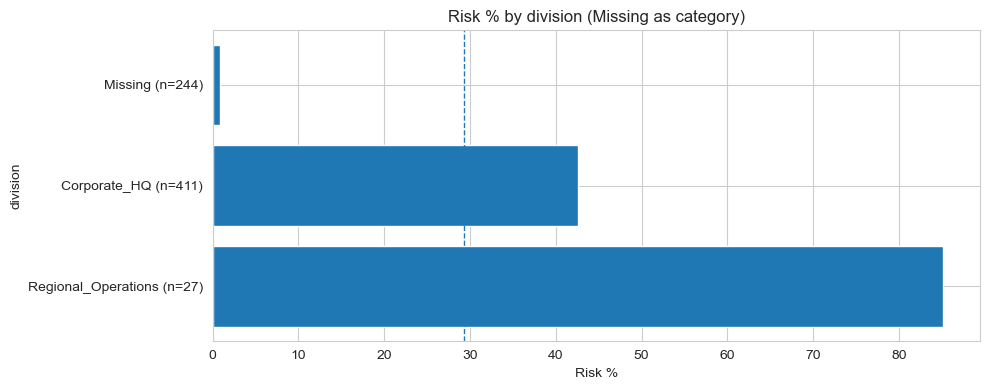

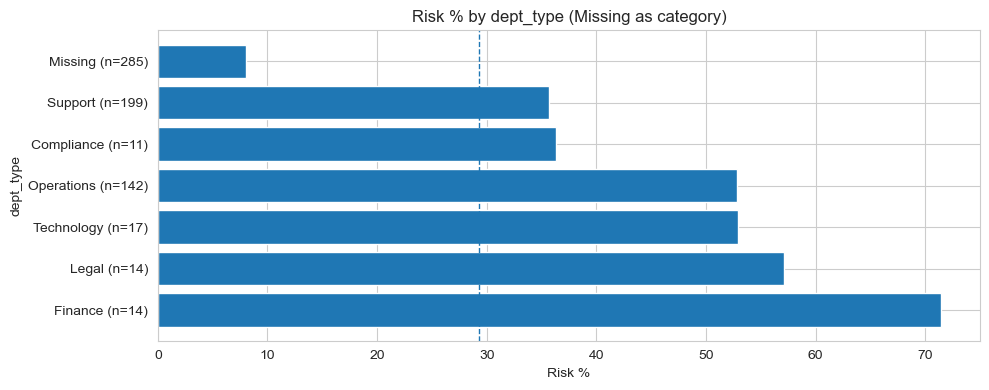

In [518]:
tab_division = plot_categorical_risk(departments, "division", min_count=10, top_n=15)
tab_dept_type = plot_categorical_risk(departments, "dept_type", min_count=10, top_n=15)


## Categorical features: risk patterns (and missingness)

To assess whether categorical attributes are associated with the target, we computed the **percentage of at-risk departments within each category** (treating missing values as an explicit `"Missing"` category). The dashed vertical line in the plots represents the **overall baseline risk rate**.

### Division
- **Regional_Operations** shows a **very high risk rate (~85%)**, while **Corporate_HQ** is substantially lower (~43%).  
  *Note:* Regional_Operations has a **small sample size (n=27)**, so this estimate should be interpreted with caution.
- The **Missing** category for `division` (n≈244) has a **near-zero risk rate**. This is a strong indicator that missingness is **not random**: departments with missing division information are rarely labeled as at risk, which may reflect **differences in audit/monitoring coverage** rather than genuinely lower risk.

### Department type (`dept_type`)
- Risk rates vary across department types. Some groups (e.g., **Operations** and **Support**) have larger sample sizes and thus provide more stable estimates.
- Several categories show high apparent risk rates (e.g., **Finance**, **Legal**, **Technology**), but these groups have **small n** (≈14–17), so the ranking among them should be considered **indicative** rather than definitive.
- As with `division`, the **Missing** category for `dept_type` (n≈285) exhibits a **much lower risk rate** than the baseline, again suggesting that missingness is **informative** and likely tied to **data collection / surveillance effects**.

### Implications
- Both `division` and `dept_type` appear to contain useful signal for predicting `is_at_risk`.
- However, the consistently low risk rate in `"Missing"` categories supports the earlier finding that missingness is **structured** and potentially linked to **monitoring intensity**. For modeling, it is therefore important to:
  - keep missingness as an explicit category (as done here) and/or add missingness indicators, and
  - interpret results carefully to avoid over-attributing predictive power to “being observed” rather than underlying risk.


### 6.4 Missing Data Analysis (Understanding Missing Values and Risk Behavior)  

In this dataset, missing information is not random.
By looking at how many fields are missing for each department and comparing it to their risk level, we see a clear pattern:  
    Departments with low risk often have many missing values, while high-risk departments have complete records.

This is a common example of surveillance bias:  The riskier the department, the more checks, documentation, and details it has.

c:\Users\morio\anaconda3\envs\compliance_radar\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


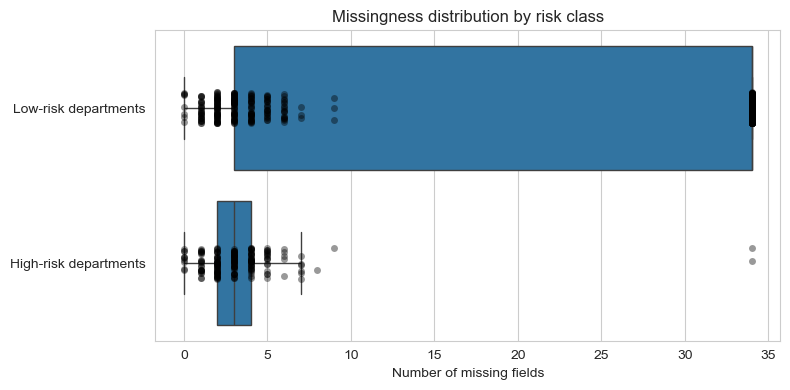

In [519]:
departments_eda = departments.copy()

# Count missing fields for each row
departments_eda['missing'] = departments_eda.isnull().sum(axis=1)

# Missing percentage
departments_eda['missing_%'] = departments_eda.isnull().mean(axis=1) * 100

# Summary by risk group
missing_stats = departments_eda.groupby('is_at_risk')[['missing', 'missing_%']].describe()
departments_eda = departments_eda.copy()
departments_eda["risk_label"] = departments_eda["is_at_risk"].map({
    0: "Low-risk departments",
    1: "High-risk departments"
})

plt.figure(figsize=(8, 4))

sns.boxplot(
    data=departments_eda,
    y="risk_label",
    x="missing",
    showfliers=False
)

sns.stripplot(
    data=departments_eda,
    y="risk_label",
    x="missing",
    color="black",
    alpha=0.4,
    jitter=True
)

plt.title("Missingness distribution by risk class")
plt.xlabel("Number of missing fields")
plt.ylabel("")
plt.tight_layout()
plt.savefig(FIGURE_DIR/'Missingness_distribution_by_risk_class.png',bbox_inches='tight',dpi=300)
plt.show()


Interpretation:

The comparison of the number of missing fields per department ( missing ) is made in the plot.
low-risk and high-risk groups.

- In the case of low-risk departments, the cloud of points is very broad in terms of missing.
between nearly no and over 30 fields. It is a high box and a large spread,
meaning that several low risk departments contain records which are very incomplete.

- In case of high-risk departments, the allocation is much more focused: the majority of the units.
and have few missing fields, and with not so great dispersion. This suggests that
the high-risk departments are checked more regularly, and therefore their information is complete.

That is, the organization gathers more systematic information that is richer on.
departments which are already considered risky, and data of seemingly safe departments.
is often sparse or missing.

This is an obvious indication of the bias of surveillances:

the likelihood of a fragment of the information being recorded is determined by the similarity between a and a.
The department is not only monitored on its actual underlying risk.

This effect will be explicitly modeled in the following steps by the construction of so-called missing-value flags,
in order that the models may make use of being missing itself as a possible warning sign, rather than
making the assumption that missing data occur due to random noise.

### 6.6 Density Plot: KDE Plot Distribution of Missingness

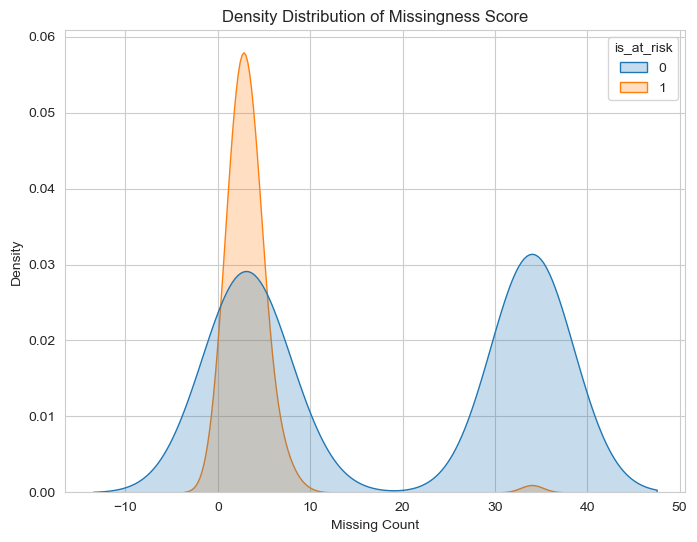

In [520]:
plt.figure(figsize = (8,6))
sns.kdeplot(data = departments_eda, x = 'missing', hue = 'is_at_risk', fill = True)
plt.title("Density Distribution of Missingness Score")
plt.xlabel("Missing Count")
plt.savefig(FIGURE_DIR/'Density_Distribution_of_Missingness_Score.png',bbox_inches='tight',dpi=300)
plt.show()

## Interpretation

The difference in behavior between low-risk and high-risk departments is clear in the density plot. **High-risk units**, marked in red usually have one to four missing fields, showing that their records are almost always complete due to regular checks and strict rules.They rarely have incomplete records, and their data is closely monitored.

On the other hand, **low-risk departments**, marked in blue show a different pattern.Their records are spread out into two groups: one group has almost ***no missing values***, while the other has many missing fields, usually ***between 30 and 40***.

This second group is important because it shows that many low-risk departments work with little oversight, leading to **incomplete** or **poorly** kept records.The lack of organized documentation happens because these units are not seen as crucial. There is little **overlap** between the two groups, which means their behaviors are quite different.

**Low-risk** departments mostly fall into the high-missing category, while high-risk departments rarely do.Overall, the pattern shows that missing information is a sign of risk.

**High-risk** units have few missing values, while many missing fields are found in low-risk departments.This is an example of surveillance bias: the areas that are checked the most have the best data, while the safer areas have less careful documentation.

### 6.7 The Connection Between Missingness and Risk

In this part, we investigate whether missing data are systematically associated with risk or exhibit a random pattern.
The analysis demonstrates that missing data follows a distinct governance pattern, closely linked to risk classification rather than being random.

In [521]:
departments_eda[['missing','is_at_risk']].corr()

,missing,is_at_risk
missing,1.000000,-0.468573
is_at_risk,-0.468573,1.000000


### Interpretation

The Correlation of **-0.47** shows a strong negative relationship.

Departments with a large number of missing fields are typically low-risk, while departments with a small number of missing fields are typically high-risk.
This supports the notion that high-risk units are closely watched, with minimal opportunity for incomplete paperwork.

### 7. Train–Test Split With Stratified Sampling

Since the dataset is imbalanced, only about **30%** of departments are labeled at risk, we use a stratified **train–test** split.

This keeps the same class proportions in both training and **test sets**.

In [522]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 0 to 708
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dept_id                          682 non-null    object 
 1   dept_name                        682 non-null    object 
 2   dept_category                    682 non-null    object 
 3   division                         438 non-null    object 
 4   dept_type                        397 non-null    object 
 5   dept_age_years                   397 non-null    float64
 6   location_type                    395 non-null    object 
 7   team_size                        393 non-null    object 
 8   reporting_structure              398 non-null    object 
 9   manager_experience_level         396 non-null    float64
 10  supervisor_experience_level      393 non-null    float64
 11  primary_function                 400 non-null    object 
 12  secondary_function         

In [523]:
X = departments.drop(columns=["is_at_risk", "dept_id", "dept_name"])
y = departments["is_at_risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size = 0.2,
    random_state = 54,
    stratify = y
)

print("Rows:", len(departments))
print("Train:", X_train.shape, "Test:", X_test.shape)

print("\nClass distribution (overall):")
print(y.value_counts(normalize=True).round(4))

print("\nClass distribution (train):")
print(y_train.value_counts(normalize=True).round(4))

print("\nClass distribution (test):")
print(y_test.value_counts(normalize=True).round(4))

Rows: 682
Train: (545, 35) Test: (137, 35)

Class distribution (overall):
is_at_risk
0    0.7067
1    0.2933
Name: proportion, dtype: float64

Class distribution (train):
is_at_risk
0    0.7064
1    0.2936
Name: proportion, dtype: float64

Class distribution (test):
is_at_risk
0    0.708
1    0.292
Name: proportion, dtype: float64


### 7.2 Adding Missingness Flags
To keep the information from missing values, we create a simple flag for each column with at least one missing value (NaN).

Each flag will be:
- 1 if the value is missing
- 0 if the value is present

These flags help the models understand that missing information is important, while the filled-in value is just an estimate.

In [524]:

X_train = X_train.copy()
X_test  = X_test.copy()


missing_flag_cols = [col for col in X_train.columns if X_train[col].isnull().any()]


for col in missing_flag_cols:
    X_train[f"{col}_missing_flag"] = X_train[col].isnull().astype(int)
    X_test[f"{col}_missing_flag"]  = X_test[col].isnull().astype(int)


print(f"Missing-flag columns created: {len(missing_flag_cols)}")
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Train/Test have identical columns:", X_train.columns.equals(X_test.columns))


Missing-flag columns created: 34
Train shape: (545, 69) | Test shape: (137, 69)
Train/Test have identical columns: True


In [525]:
# Binary (0/1) governance and control indicators
binary_cols = [
    "remediation_plan_active", "executive_support", "external_consulting",
    "engagement_programs", "onboarding_program", "improvement_commitment",
    "digital_systems", "external_partnerships"
]

#Ordinal scores: higher values = “more” of something
ordinal_cols = [
    "manager_experience_level", "supervisor_experience_level",
    "interdept_collaboration_score", "resource_availability_score",
    "external_interactions_frequency", "risk_exposure_operational",
    "risk_exposure_financial", "operational_health_index"
]

# All numeric columns (including flags, but we will filter them)
numeric_cols = X_train.select_dtypes(include="number").columns

# Continuous numeric variables (for later: median imputation / scaling)
continuous_cols = [
    c for c in numeric_cols
    if c not in binary_cols
    and c not in ordinal_cols
    and c != target
    and not c.endswith("_missing_flag")
]

#### Binary columns

In [526]:
X_train[binary_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
remediation_plan_active,320.0,0.196875,0.398260,0.0,0.0,0.0,0.0,1.0
executive_support,323.0,0.597523,0.491158,0.0,0.0,1.0,1.0,1.0
external_consulting,321.0,0.121495,0.327212,0.0,0.0,0.0,0.0,1.0
engagement_programs,320.0,0.521875,0.500304,0.0,0.0,1.0,1.0,1.0
onboarding_program,319.0,0.746082,0.435935,0.0,0.0,1.0,1.0,1.0
improvement_commitment,327.0,0.859327,0.348217,0.0,1.0,1.0,1.0,1.0
digital_systems,316.0,0.778481,0.415928,0.0,1.0,1.0,1.0,1.0
external_partnerships,321.0,0.348910,0.477369,0.0,0.0,0.0,1.0,1.0


#### Ordinal columns

In [527]:
X_train[ordinal_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
manager_experience_level,321.0,2.616822,1.167087,0.0,2.0,3.0,4.0,4.0
supervisor_experience_level,322.0,2.419255,1.138946,0.0,2.0,2.0,3.0,4.0
interdept_collaboration_score,315.0,3.834921,1.027358,1.0,3.0,4.0,5.0,5.0
resource_availability_score,317.0,3.189274,1.062365,1.0,3.0,3.0,4.0,5.0
external_interactions_frequency,316.0,3.098101,1.208382,1.0,2.0,3.0,4.0,5.0
risk_exposure_operational,327.0,1.666667,1.135953,1.0,1.0,1.0,2.0,5.0
risk_exposure_financial,317.0,2.293375,1.352115,1.0,1.0,2.0,3.0,5.0
operational_health_index,322.0,3.453416,1.433686,1.0,2.0,4.0,5.0,5.0


#### Continuos columns

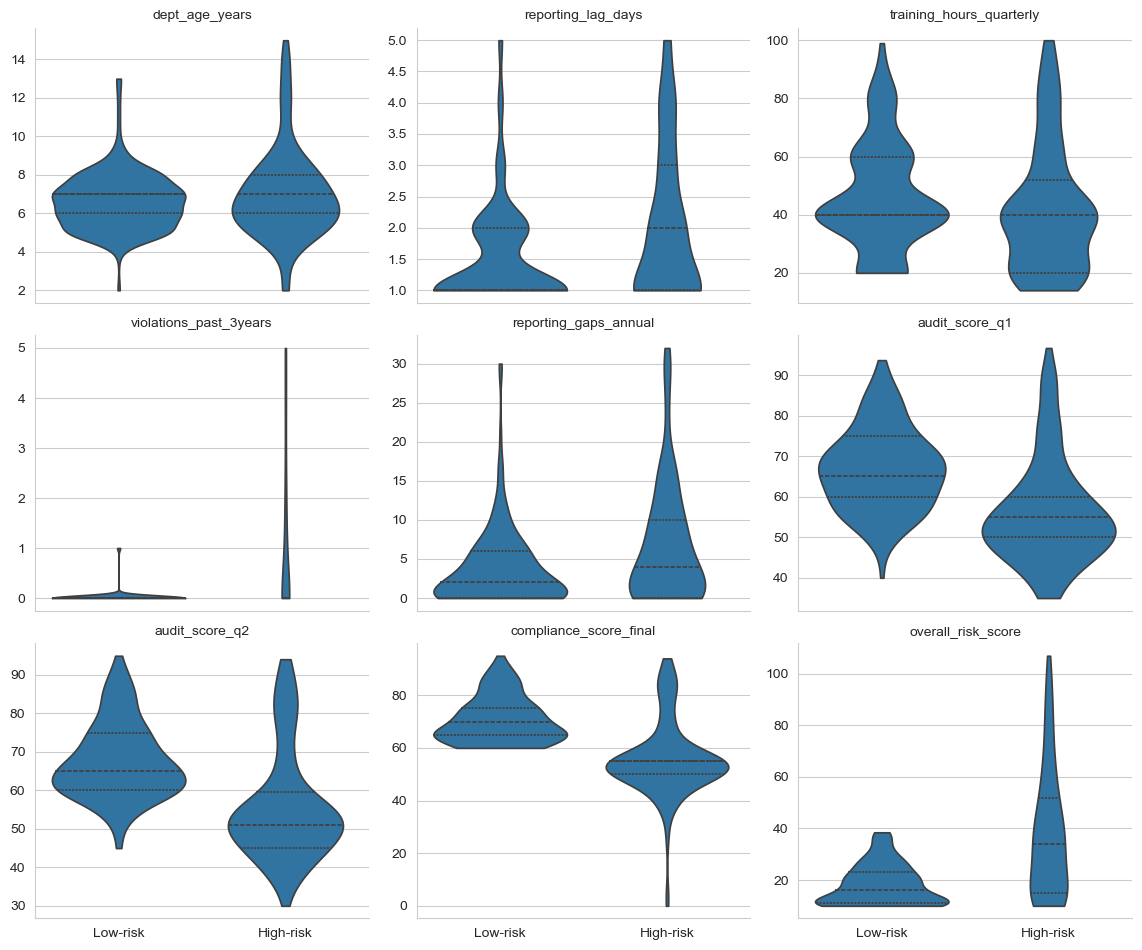

In [528]:

plot_df = X_train[continuous_cols].copy()
plot_df["risk_label"] = y_train.map({0: "Low-risk", 1: "High-risk"}).values

# Convert to long format for FacetGrid
long_df = plot_df.melt(
    id_vars="risk_label",
    value_vars=continuous_cols,
    var_name="feature",
    value_name="value"
).dropna()

# Grid of violin plots
g = sns.FacetGrid(
    long_df,
    col="feature",
    col_wrap=3,        # 3 plots per row (change to 2/4 if you want)
    sharey=False,
    height=3.2,
    aspect=1.2
)

g.map_dataframe(
    sns.violinplot,
    x="risk_label",
    y="value",
    cut=0,
    inner="quartile"
)

# Improve readability
g.set_axis_labels("", "")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.savefig(FIGURE_DIR / "violin_grid_continuous_by_risk.png", dpi=300, bbox_inches="tight")
plt.show()


### 7.3 Imputation pipelines
We will impute:
* Binary features -> Mode
* Ordinal features -> Median
* Continuos features -> Median

In [529]:
def round_to_int(X):
    return np.rint(X).astype(int)

binary_pipe= Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
]
)

ordinal_pipe= Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ("round_int", FunctionTransformer(round_to_int, feature_names_out="one-to-one"))
])

continuous_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

preprocess_num = ColumnTransformer(
    transformers=[
        ("bin", binary_pipe, binary_cols),
        ("ord", ordinal_pipe, ordinal_cols),
        ("cont", continuous_pipe, continuous_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

preprocess_num.set_output(transform="pandas")


X_train_imp = preprocess_num.fit_transform(X_train)
X_test_imp  = preprocess_num.transform(X_test)

print("X_train_imp:", X_train_imp.shape)
print("X_test_imp :", X_test_imp.shape)

check_cols = binary_cols + ordinal_cols + continuous_cols
print("NaN numeriche (train):", X_train_imp[check_cols].isna().sum().sum())
print("NaN numeriche (test) :", X_test_imp[check_cols].isna().sum().sum())

X_train_imp: (545, 69)
X_test_imp : (137, 69)
NaN numeriche (train): 0
NaN numeriche (test) : 0


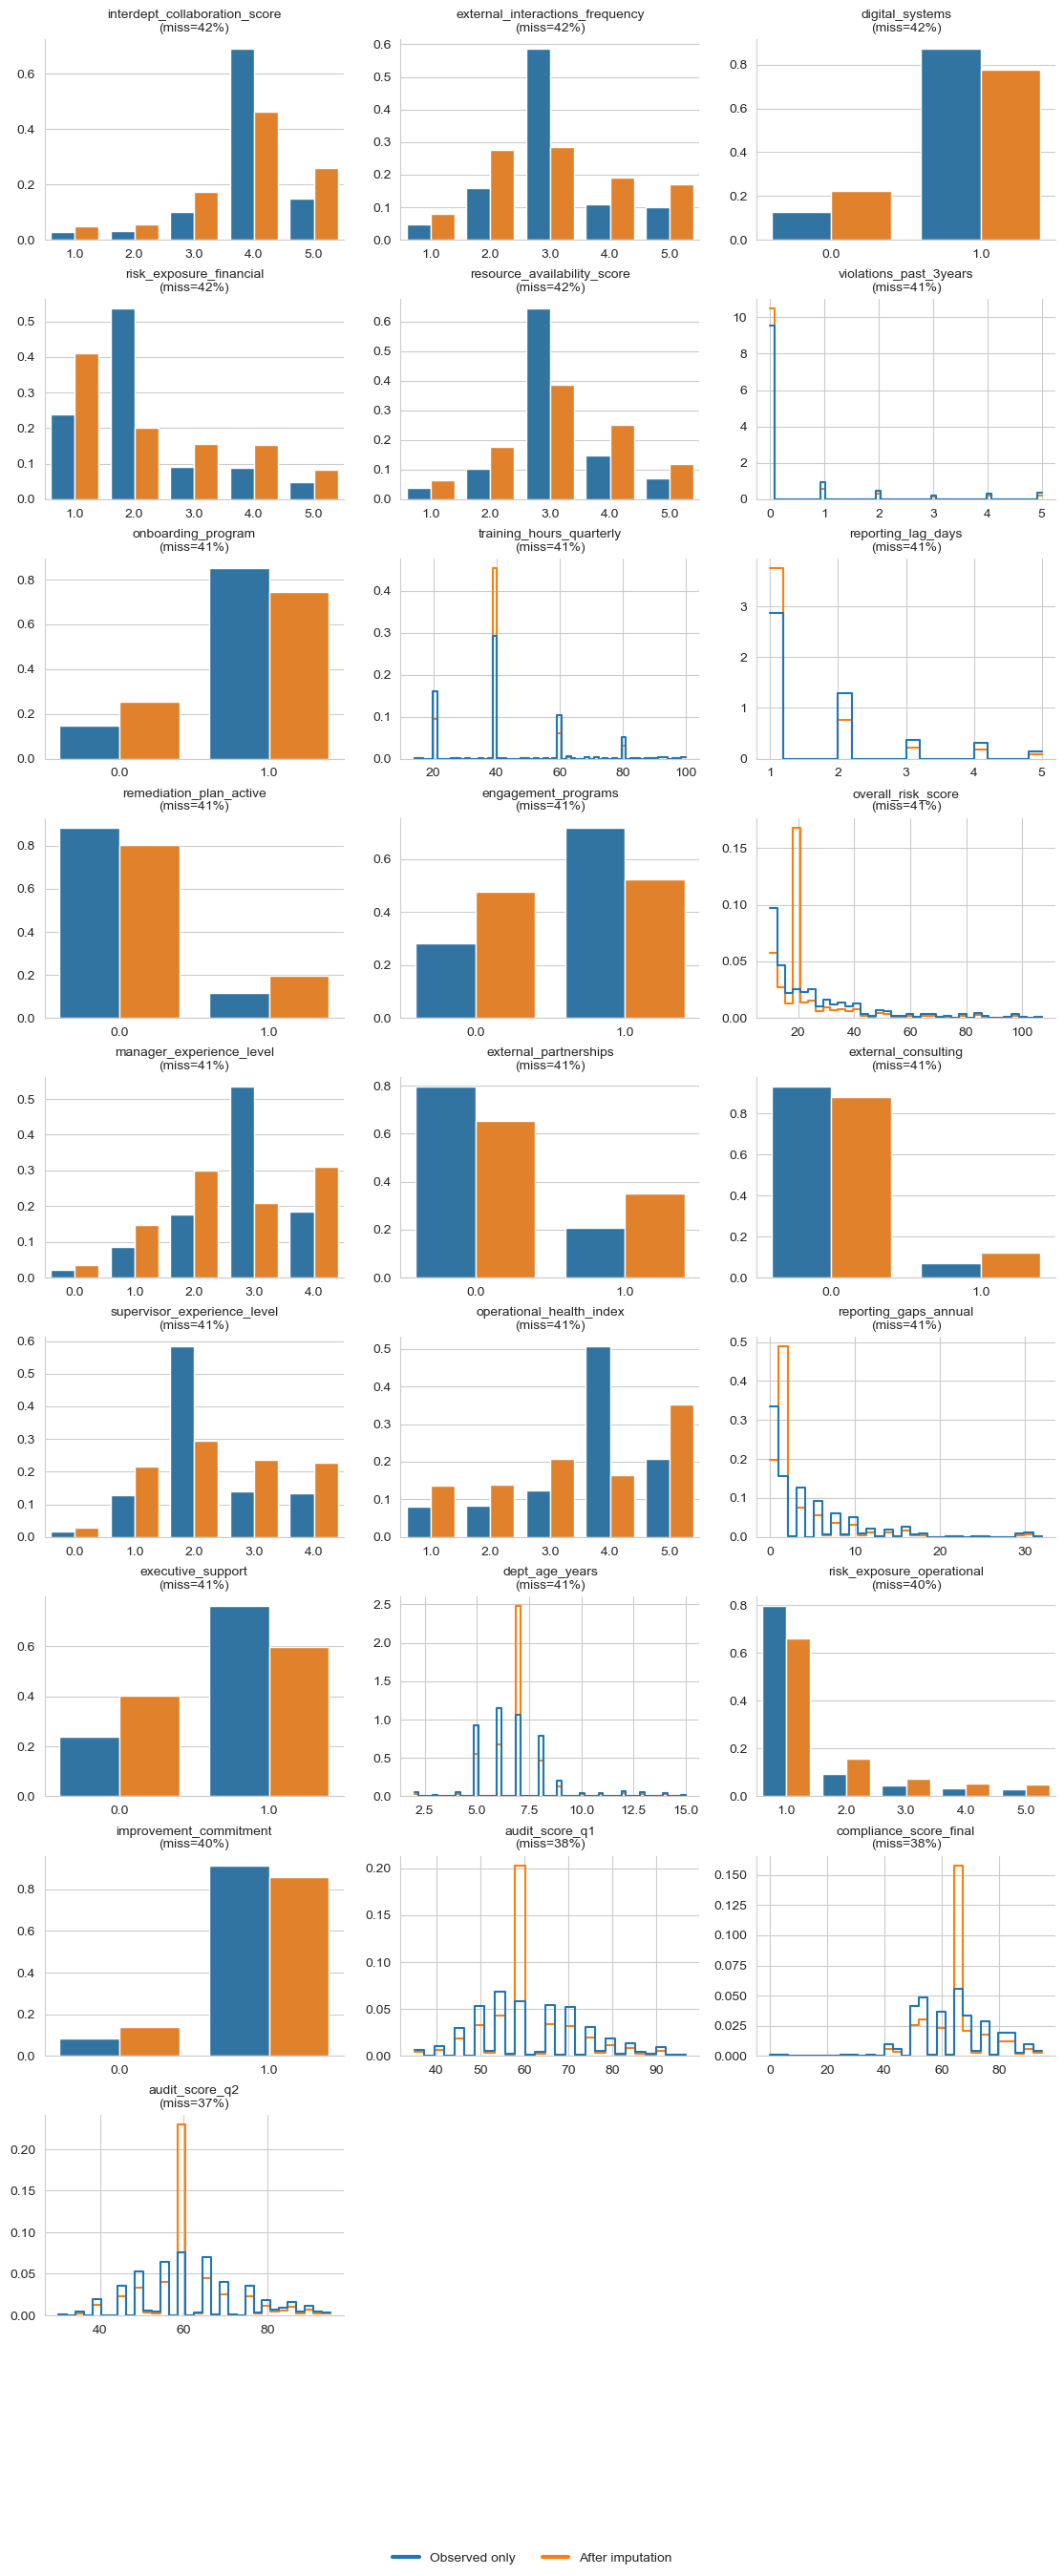

In [530]:


COL_WRAP = 3
SAVE = True
OUTFILE = "imputation_check_grid_intelligent.png"


all_plot_cols = []
for lst in [binary_cols, ordinal_cols, continuous_cols]:
    all_plot_cols.extend(lst)


miss_rate = X_train[all_plot_cols].isna().mean().sort_values(ascending=False)
cols_ordered = miss_rate.index.tolist()


dfs = []
for c in cols_ordered:
    mr = miss_rate.loc[c]
    label = f"{c}\n(miss={mr:.0%})"
    ctype = "binary" if c in binary_cols else ("ordinal" if c in ordinal_cols else "continuous")

    obs = X_train[c].dropna()
    aft = X_train_imp[c].dropna()

    dfs.append(pd.DataFrame({"feature": label, "value": obs.values, "dataset": "Observed only", "type": ctype}))
    dfs.append(pd.DataFrame({"feature": label, "value": aft.values, "dataset": "After imputation", "type": ctype}))

grid_df = pd.concat(dfs, ignore_index=True)


def plot_panel(data, **kws):
    ax = plt.gca()
    t = data["type"].iloc[0]

    if t in ("binary", "ordinal"):
        tab = (
            data.groupby("dataset")["value"]
                .value_counts(normalize=True)
                .rename("prop")
                .reset_index()
        )

       
        x_order = sorted(tab["value"].unique())

        sns.barplot(
            data=tab,
            x="value",
            y="prop",
            hue="dataset",
            order=x_order,
            ax=ax
        )
        ax.set_ylabel("Proportion")
        ax.set_xlabel("")
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()

    else:
        sns.histplot(
            data=data,
            x="value",
            hue="dataset",
            element="step",
            stat="density",
            common_norm=False,
            bins="auto",
            fill=False,
            ax=ax,
            legend=False
        )
        ax.set_ylabel("Density")
        ax.set_xlabel("")


g = sns.FacetGrid(
    grid_df,
    col="feature",
    col_wrap=COL_WRAP,
    sharex=False,
    sharey=False,
    height=3.0,
    aspect=1.25
)

g.map_dataframe(plot_panel)
g.set_titles("{col_name}")
g.set_axis_labels("", "")

handles = [
    plt.Line2D([0], [0], color="C0", lw=3, label="Observed only"),
    plt.Line2D([0], [0], color="C1", lw=3, label="After imputation"),
]
g.fig.legend(handles=handles, loc="lower center", ncol=2, frameon=False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.10)

if SAVE:
    plt.savefig(FIGURE_DIR / OUTFILE, dpi=300, bbox_inches="tight")

plt.show()


### **Imputation sanity check (distribution comparison)**

After defining the imputation rules (mode for binary variables, median for ordinal variables, median for continuous variables) we validated the impact of imputation by comparing, on the training set only, the distributions of:

Observed-only values (rows where the feature was originally present), vs.

After-imputation values (including the newly imputed entries).

The comparison confirms the expected behavior:

* Binary features (0/1) show an increased mass on the most frequent value, which is consistent with mode imputation.

* Ordinal features (1–5) show a stronger concentration around the median level (typically 3–4), as expected when filling missing values with the median.

* Zero-inflated variables (e.g., violations counts) show a clear increase at 0, which is the median and the most common value in the observed data.

* Continuous variables preserve the overall shape of the observed distribution, with an additional peak around the median due to the imputed values.

Most importantly, because missingness in this dataset is structured and related to governance/oversight, the imputed values should be interpreted as placeholders rather than true measurements. For this reason, we retain the information carried by missingness through missingness flags, which allow the model to distinguish between observed values and imputed values and therefore learn potential surveillance/documentation effects directly from the data.

### 7.4 Preparing Categorical Variables for Target Encoding

Now we have a correct distribution in both sets.

We will procede with target encoding. Since we have a huge amount of features, all the missing flag that preserve the missing signal, we don't want to add other columns like in the 1 hot encoding case. Because the risk of overfitting would increase.

In [531]:
# 1) Categorical (object) columns
cat_all = X_train_imp.select_dtypes(include=["object"]).columns.tolist()
print("All object cols:", cat_all)

# 2) Exclude ID columns if present
cat_cols = [c for c in cat_all if c not in id_cols]
print("Categorical columns to impute:", cat_cols)

# 3) Fill NaN only in categorical columns (train + test)
X_train_imp[cat_cols] = X_train_imp[cat_cols].fillna("Missing")
X_test_imp[cat_cols]  = X_test_imp[cat_cols].fillna("Missing")

# Sanity check
print("Remaining NaN in categorical (train):", X_train_imp[cat_cols].isna().sum().sum())
print("Remaining NaN in categorical (test):",  X_test_imp[cat_cols].isna().sum().sum())


All object cols: ['dept_category', 'division', 'dept_type', 'location_type', 'team_size', 'reporting_structure', 'primary_function', 'secondary_function', 'creation_reason', 'oversight_body']
Categorical columns to impute: ['dept_category', 'division', 'dept_type', 'location_type', 'team_size', 'reporting_structure', 'primary_function', 'secondary_function', 'creation_reason', 'oversight_body']
Remaining NaN in categorical (train): 0
Remaining NaN in categorical (test): 0


#### 7.5 Logic for Target Encoding (Train Set Only)

We introduce for each categorical column (col) and  for every category value a **smoothed target encoding**:

$TE(\text{category}) = \frac{n_c \cdot mean_c + \alpha \cdot global\_mean}{n_c + \alpha}$

- n_c is the number of records in the train set that fall into that category;
- mean_c is the average of is_at_risk for that category.
- global_mean = the train set's overall mean of is_at_risk (≈ 0.30)
- α is the smoothing parameter, such as 10.

Because encodings are only learnt from the train set and then applied to both **train and test**, this method decreases overfitting, stabilises unusual categories by bringing them towards the global mean, and prevents leaking.

In [532]:
def target_encode_column(train_col, y_train, test_col, alpha = 10.0):
    """
    train_col: Pd.series with categorical features in train set
    y_train:   training target
    test_col:  Pd.series same as train_col but in test set
    alpha:     smoothing factor
    """
    global_mean = y_train.mean() #train global mean

    stats = (pd.DataFrame({'col': train_col, 'y': y_train}).groupby('col')['y'].agg(['mean', 'count']))

    smooth = (stats['mean'] * stats['count'] + global_mean * alpha) / (stats['count'] + alpha)

    stats['te'] = smooth

    # Mapping train
    train_te = train_col.map(stats['te']).fillna(global_mean)
    # Mapping test
    test_te = test_col.map(stats['te']).fillna(global_mean) #some categories might not exist in test set

    return train_te, test_te, stats, global_mean

In [533]:

encoding_stats = {}  # to check the stats

for col in cat_cols:
    train_encoded, test_encoded, stats, global_mean = target_encode_column(
        X_train_imp[col], y_train, X_test_imp[col], alpha=10.0
    )

    new_col = f"{col}_te" #save the new column
    X_train_imp[new_col] = train_encoded
    X_test_imp[new_col] = test_encoded

    #saving stats for analysis
    encoding_stats[col] = {"global_mean": global_mean, "stats": stats.sort_values("te", ascending=False)}

    print(f"Encoded {col} -> {new_col} (example categories):")
    print(encoding_stats[col]["stats"].head(), "\n")

Encoded dept_category -> dept_category_te (example categories):
                            mean  count        te
col                                              
Risk_Management         0.857143     21  0.675348
Financial_Reporting     0.404908    326  0.401595
Operational_Compliance  0.050505    198  0.062191 

Encoded division -> division_te (example categories):
                         mean  count        te
col                                           
Regional_Operations  0.857143     21  0.675348
Corporate_HQ         0.417910    335  0.414307
Missing              0.010582    189  0.024803 

Encoded dept_type -> dept_type_te (example categories):
                mean  count        te
col                                  
Finance     0.769231     13  0.562425
Operations  0.553571    112  0.532260
Legal       0.615385     13  0.475469
Technology  0.384615     13  0.345034
Support     0.339394    165  0.336776 

Encoded location_type -> location_type_te (example categories):
     

In [534]:
X_train_imp = X_train_imp.drop(columns = cat_cols)
X_test_imp = X_test_imp.drop(columns = cat_cols)

print("Final train shape:", X_train_imp.shape)
print("Final test shape:", X_test_imp.shape)

Final train shape: (545, 69)
Final test shape: (137, 69)


### 7.6 Why Target Encoding (and how EDA supports it)

The analysis reveals significant changes in the likelihood of being classified as at risk, based on various categories. **Target encoding** is identified as the most effective method, with departments like Risk Management associated with **high-risk** scenarios, while Operational Compliance aligns with low-risk situations.

Additionally, Corporate HQ displays markedly **lower risk** levels compared to Regional Operations, with other influencing factors including location, team size, and reporting structures also exThe reasoning behind why target encoding is important (and how EDA can help)

The EDA indicates that the likelihood of being at risk is different significantly among.
numerous nominal dimensions:

- at-risk rates are far greater in such departments as the *Risk Management* or other departments.
Although such domains as *Operational Compliance* are less likely to cause risks;
- *Corporate HQ* is likely to look safer than regional or operation divisions;
- other nominal attributes (location, team size bands, reporting structure, creation
the risk level of reason, oversight body, etc.) also is different.

These trends imply that even category membership is highly risky information.
To add this information to the models, target encoding gives a concise means to inject this information.
category is associated to a smoothed approximation of the at-risk rate on that category.

In comparison to a naive one-hot encoding:

- target encoding leaves the feature space incomparably smaller (one column per variable instead).
of large numbers of dummy columns, as is of importance, because we have a small sample;
- it generates quantities in numbers that can be directly interpreted as risk indicators, and these are effective.
using such models as Logistic Regression and tree-based ones;
- by using a smoothed formula


we stabilise the rare categories (n_c small) by bringing them nearer to the global average,
overfitting and noise reduction.

More importantly, all encodings are only fitted on the training set (X train, y train ).
and subsequently subjected to train and test. This prevents information leakage of the test.
labels and makes sure that the hold-out test set is a fair point of model evaluation.

Another finding presented in the EDA was that certain categories were present in some of the variables including main function, secondary.
function, creation reason and oversight body are relatively uncommon, and the absence of them.
Patterns are systematically different in low and high-risk departments. This reinforces
the choice of:

- with the help of smoothed target encoding to get strong estimates of infrequent categories;
- using missing values and indicators of missingness as two separate and informative features,
extremely similar to surveillance bias.

In general, target encoding provides a sufficient trade-off to this project: it makes things easier.
representation of categorical variables, maintains the important risk signals in.
the EDA, and gives smaller and a modelling-friendly dataset.hibiting varying risk levels.

Traditional one-hot encoding would overlook these critical patterns, complicating the data representation. In contrast, target encoding effectively associates categories with risk estimates, aiding the model in learning from the data. It is essential to calculate encodings **only on the training set** to maintain the integrity of the model, preventing contamination of training and testing data. This ensures a clear distinction and fairness in model evaluation.

The findings indicate that certain categories, particularly in main function, secondary function, creation reason, and oversight body, are infrequent. Rare categories can lead to unreliable estimates, but applying a smoothing method helps stabilize values and reduces noise.

Another key observation is the **correlation** between ***missing values and risk levels***; low-risk departments tend to exhibit more missing information, while high-risk departments generally have complete records. This suggests that missing values might reflect behavioral patterns rather than directly impacting outcomes, allowing for their continued use as informative features.

In conclusion, the insights gathered advocate for target encoding due to its ability to simplify data handling compared to one-hot encoding, preserve essential category signals, and enhance the stability of estimates for rare categories.

Consequently, the dataset is improved for modeling, resulting in a more compact and valuable format.

### 8. Feature Engineering: Composite Indicators with a Risk Focus

We develop a collection of engineering features that summarize **governance quality, operational complexity, behavioral risk, and documentation discipline** in order to assist the model in identifying the minority ***at-risk class***.

In [535]:
import numpy as np

SELECTED_ENGINEERED = [
    "governance_support_index",
    "operational_complexity",
    "audit_trend",
    "audit_volatility",
    "experience_gap",
    "training_efficiency",
    "risk_gap",
    "reporting_discipline",
    "governance_weakness_flag",
    "exposure_capacity_mismatch",
]

gov_cols = [
    "executive_support","remediation_plan_active","improvement_commitment",
    "engagement_programs","onboarding_program","digital_systems"
]

def add_selected_engineered_features(df):
    df = df.copy()

    # Governance support (mean of binary support indicators)
    df["governance_support_index"] = df[gov_cols].mean(axis=1)

    # Operational complexity
    df["operational_complexity"] = df["risk_exposure_operational"] * df["external_interactions_frequency"]

    # Audit trend + volatility
    df["audit_trend"] = df["audit_score_q2"] - df["audit_score_q1"]
    df["audit_volatility"] = (df["audit_score_q2"] - df["audit_score_q1"]).abs()

    # Experience gap
    df["experience_gap"] = df["manager_experience_level"] - df["supervisor_experience_level"]

    # Training efficiency (robust denominator)
    df["training_efficiency"] = df["training_hours_quarterly"] / (1.0 + df["violations_past_3years"])

    # Risk gap (exposure - resilience)
    df["risk_gap"] = df["risk_exposure_operational"] - df["operational_health_index"]

    # Reporting discipline (normalize lag)
    df["reporting_discipline"] = df["reporting_gaps_annual"] + (df["reporting_lag_days"] / 10.0)

    # Governance weakness flag
    df["governance_weakness_flag"] = (
        (df["executive_support"] == 0) & (df["improvement_commitment"] == 0)
    ).astype(int)

    # Exposure-capacity mismatch (robust denominator)
    df["exposure_capacity_mismatch"] = df["risk_exposure_operational"] / (df["resource_availability_score"] + 1.0)

    # Return only the engineered columns (or keep everything; scegli tu)
    # Qui: le aggiungo e poi restituisco df completo
    return df


X_train_fe = add_selected_engineered_features(X_train_imp)
X_test_fe  = add_selected_engineered_features(X_test_imp)


print("Train shape:", X_train_fe.shape, "| Test shape:", X_test_fe.shape)
print("Same columns?", X_train_fe.columns.equals(X_test_fe.columns))

missing_created = [c for c in SELECTED_ENGINEERED if c not in X_train_fe.columns]
print("Missing engineered columns (should be empty):", missing_created)


print("NaN in engineered (train):", X_train_fe[SELECTED_ENGINEERED].isna().sum().sum())
print("NaN in engineered (test): ", X_test_fe[SELECTED_ENGINEERED].isna().sum().sum())


Train shape: (545, 79) | Test shape: (137, 79)
Same columns? True
Missing engineered columns (should be empty): []
NaN in engineered (train): 0
NaN in engineered (test):  0


### 9. Leakage check and feature removal (audit-related variables)

Because `is_at_risk` is derived from an external list of “high-risk departments”, any variables that are direct audit outcomes (or very close proxies of the risk labeling process) can introduce **information leakage** and inflate performance unrealistically.

To mitigate this risk, we explicitly identified and removed:
- **Audit outcome variables**: `audit_score_q1`, `audit_score_q2`
- **Primary compliance outcome** (listed as the main target in the data dictionary): `compliance_score_final`
- **Composite score likely derived from risk factors**: `overall_risk_score`
- **Engineered features derived from audit scores**: `audit_trend`, `audit_volatility`
- The corresponding **missingness flags** for the removed variables (to keep the feature space consistent)

We apply the removal consistently to both train and test sets.


In [536]:

LEAKY_BASE = [
    "compliance_score_final",
    "audit_score_q1",
    "audit_score_q2",
    "overall_risk_score",      
]


LEAKY_ENGINEERED = [
    "audit_trend",
    "audit_volatility",
]


def flags_for(cols, df):
    return [f"{c}_missing_flag" for c in cols if f"{c}_missing_flag" in df.columns]

# 4) (Opzionale) pattern-based: se vuoi essere aggressivo su "audit"/"compliance_score"
def pattern_leaky(df):
    pat = re.compile(r"(audit_|_audit|compliance_score_final|overall_risk_score)", re.IGNORECASE)
    return [c for c in df.columns if pat.search(c)]

def drop_leaky(X_train, X_test, aggressive=False):
    drop_cols = set(LEAKY_BASE + LEAKY_ENGINEERED)
    drop_cols |= set(flags_for(LEAKY_BASE, X_train))
    drop_cols |= set(flags_for(LEAKY_BASE, X_test))

    if aggressive:
        drop_cols |= set(pattern_leaky(X_train))
        drop_cols |= set(pattern_leaky(X_test))

    drop_cols = sorted(drop_cols)

    X_train_clean = X_train.drop(columns=drop_cols, errors="ignore")
    X_test_clean  = X_test.drop(columns=drop_cols, errors="ignore")

    print("Dropped columns:", drop_cols)
    print("Train shape:", X_train.shape, "->", X_train_clean.shape)
    print("Test shape :", X_test.shape,  "->", X_test_clean.shape)
    print("Same columns?", X_train_clean.columns.equals(X_test_clean.columns))

    return X_train_clean, X_test_clean, drop_cols




In [537]:

Xtr = X_train_imp 
Xte = X_test_imp 


candidate_leaky = LEAKY_BASE + LEAKY_ENGINEERED + [f"{c}_missing_flag" for c in LEAKY_BASE]
present_leaky = [c for c in candidate_leaky if c in Xtr.columns]
print("Leaky candidates present in TRAIN:", present_leaky)

X_train_model, X_test_model, dropped = drop_leaky(Xtr, Xte, aggressive=False)


print("\nFinal shapes for modeling:")
print("Train:", X_train_model.shape)
print("Test :", X_test_model.shape)
print("Same columns:", X_train_model.columns.equals(X_test_model.columns))


Leaky candidates present in TRAIN: ['compliance_score_final', 'audit_score_q1', 'audit_score_q2', 'overall_risk_score', 'compliance_score_final_missing_flag', 'audit_score_q1_missing_flag', 'audit_score_q2_missing_flag', 'overall_risk_score_missing_flag']
Dropped columns: ['audit_score_q1', 'audit_score_q1_missing_flag', 'audit_score_q2', 'audit_score_q2_missing_flag', 'audit_trend', 'audit_volatility', 'compliance_score_final', 'compliance_score_final_missing_flag', 'overall_risk_score', 'overall_risk_score_missing_flag']
Train shape: (545, 69) -> (545, 61)
Test shape : (137, 69) -> (137, 61)
Same columns? True

Final shapes for modeling:
Train: (545, 61)
Test : (137, 61)
Same columns: True


### Leakage removal results

The leakage check confirmed that all selected audit/compliance-related variables were present in the training data and were successfully removed from both splits.

- Dropped columns (including missingness flags):  
  `audit_score_q1`, `audit_score_q2`, `compliance_score_final`, `overall_risk_score`,  
  `audit_trend`, `audit_volatility`, and their `*_missing_flag` counterparts.

- Dataset shapes after removal:
  - Train: **(545, 79) → (545, 71)**
  - Test: **(137, 79) → (137, 71)**

Both train and test retain **exactly the same feature set**, ensuring that downstream modeling is performed on a **leakage-reduced (pre-audit) feature space**.

### 10. Logistic Regression: Baseline Linear Model

Train: (545, 61) Test: (137, 61)
Any object cols in Xtr? False
Fitting 10 folds for each of 30 candidates, totalling 300 fits

Best CV ROC-AUC: 0.8913503711201078
Best params: {'logreg__C': 1, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}

TEST ROC-AUC: 0.8713917525773196

Classification report (test):
               precision    recall  f1-score   support

           0     0.8646    0.8557    0.8601        97
           1     0.6585    0.6750    0.6667        40

    accuracy                         0.8029       137
   macro avg     0.7616    0.7653    0.7634       137
weighted avg     0.8044    0.8029    0.8036       137


Confusion matrix (test):
 [[83 14]
 [13 27]]


<Figure size 640x480 with 0 Axes>

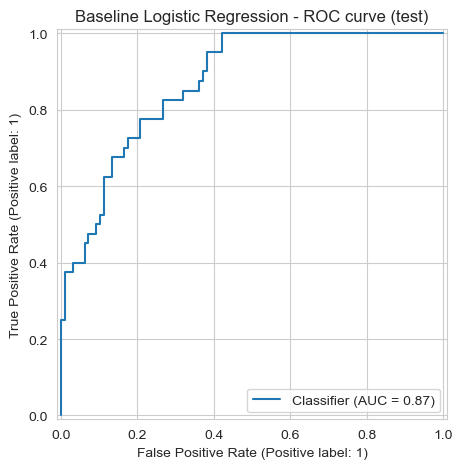

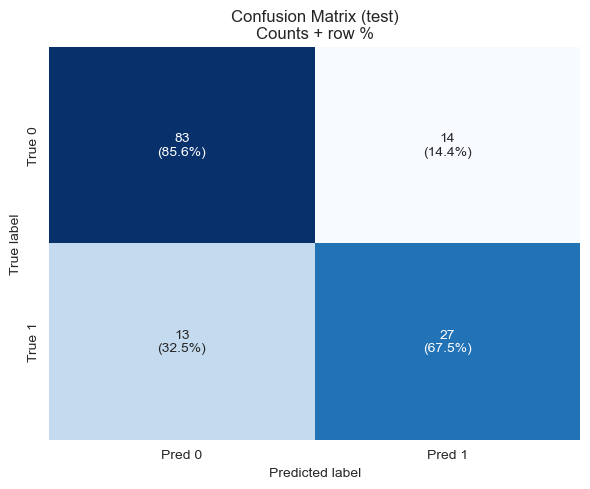

In [538]:

warnings.filterwarnings("ignore", category=FutureWarning)

Xtr, ytr = X_train_model.copy(), y_train.copy()
Xte, yte = X_test_model.copy(), y_test.copy()

ytr = pd.Series(ytr).squeeze()
yte = pd.Series(yte).squeeze()

print("Train:", Xtr.shape, "Test:", Xte.shape)
print("Any object cols in Xtr?", (Xtr.dtypes == "object").any())

pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=5000, random_state=42))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

param_grid = [
    {
        "logreg__solver": ["lbfgs"],
        "logreg__penalty": ["l2"],
        "logreg__C": [0.01, 0.1, 1, 10, 100],
        "logreg__class_weight": [None, "balanced"],
    },
    {
        "logreg__solver": ["liblinear"],
        "logreg__penalty": ["l1", "l2"],
        "logreg__C": [0.01, 0.1, 1, 10, 100],
        "logreg__class_weight": [None, "balanced"],
    }
]

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit
grid.fit(Xtr, ytr)

print("\nBest CV ROC-AUC:", grid.best_score_)
print("Best params:", grid.best_params_)

# TEST EVAL

best_model = grid.best_estimator_

y_proba = best_model.predict_proba(Xte)[:, 1]
y_pred  = best_model.predict(Xte)

print("\nTEST ROC-AUC:", roc_auc_score(yte, y_proba))
print("\nClassification report (test):\n", classification_report(yte, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(yte, y_pred, labels=[0, 1])
print("\nConfusion matrix (test):\n", cm)


plt.figure()
RocCurveDisplay.from_predictions(yte, y_proba)
plt.title("Baseline Logistic Regression - ROC curve (test)")
plt.tight_layout()
plt.savefig(FIGURE_DIR / "baseline_logreg_roc_test.png", dpi=300, bbox_inches="tight")
plt.show()


cm_norm = cm / cm.sum(axis=1, keepdims=True)  

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i, j]}\n({cm_norm[i, j]*100:.1f}%)"

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm_norm,
    annot=annot,
    fmt="",
    cmap="Blues",
    cbar=False,
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)
plt.title("Confusion Matrix (test)\nCounts + row %")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig(FIGURE_DIR / "baseline_logreg_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


In [539]:

logreg = best_model.named_steps["logreg"]
coefs = logreg.coef_.ravel()
feat_names = Xtr.columns

coef_df = pd.DataFrame({
    "feature": feat_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs),
    "odds_ratio_per_1std": np.exp(coefs)
}).sort_values("abs_coef", ascending=False)

print("\nTop 15 drivers (|coef|):")
display(coef_df.head(15))

print("\nTop 10 increasing risk (positive coef):")
display(coef_df.sort_values("coef", ascending=False).head(10)[["feature","coef","odds_ratio_per_1std"]])

print("\nTop 10 decreasing risk (negative coef):")
display(coef_df.sort_values("coef", ascending=True).head(10)[["feature","coef","odds_ratio_per_1std"]])



Top 15 drivers (|coef|):


,feature,coef,abs_coef,odds_ratio_per_1std
19,violations_past_3years,1.929392,1.929392,6.885323
22,dept_type_missing_flag,1.300341,1.300341,3.670547
58,secondary_function_te,1.137988,1.137988,3.120483
53,dept_type_te,1.069996,1.069996,2.915367
41,improvement_commitment_missing_flag,-0.888014,0.888014,0.411472
29,primary_function_missing_flag,0.722604,0.722604,2.059790
13,risk_exposure_operational,0.722462,0.722462,2.059498
30,secondary_function_missing_flag,0.686714,0.686714,1.987174
42,digital_systems_missing_flag,-0.626778,0.626778,0.534310
59,creation_reason_te,0.616968,0.616968,1.853300



Top 10 increasing risk (positive coef):


,feature,coef,odds_ratio_per_1std
19,violations_past_3years,1.929392,6.885323
22,dept_type_missing_flag,1.300341,3.670547
58,secondary_function_te,1.137988,3.120483
53,dept_type_te,1.069996,2.915367
29,primary_function_missing_flag,0.722604,2.059790
13,risk_exposure_operational,0.722462,2.059498
30,secondary_function_missing_flag,0.686714,1.987174
59,creation_reason_te,0.616968,1.853300
35,violations_past_3years_missing_flag,0.609244,1.839041
57,primary_function_te,0.570674,1.769459



Top 10 decreasing risk (negative coef):


,feature,coef,odds_ratio_per_1std
41,improvement_commitment_missing_flag,-0.888014,0.411472
42,digital_systems_missing_flag,-0.626778,0.534310
25,team_size_missing_flag,-0.451808,0.636476
48,risk_exposure_financial_missing_flag,-0.441497,0.643073
2,external_consulting,-0.438815,0.644800
18,training_hours_quarterly,-0.389746,0.677229
50,reporting_gaps_annual_missing_flag,-0.327003,0.721081
43,external_partnerships_missing_flag,-0.323667,0.723491
38,external_consulting_missing_flag,-0.321137,0.725324
5,improvement_commitment,-0.311436,0.732394


In [540]:

Xtr, ytr = X_train_model.copy(), pd.Series(y_train).squeeze()
Xte, yte = X_test_model.copy(), pd.Series(y_test).squeeze()

flag_cols = [c for c in Xtr.columns if c.endswith("_missing_flag")]

rows = []
for c in flag_cols:

    p1 = ytr[Xtr[c] == 1].mean() if (Xtr[c] == 1).any() else np.nan
    p0 = ytr[Xtr[c] == 0].mean() if (Xtr[c] == 0).any() else np.nan
    n1 = int((Xtr[c] == 1).sum())
    n0 = int((Xtr[c] == 0).sum())
    rows.append({"flag": c, "n_flag1": n1, "risk_rate_flag1": p1, "n_flag0": n0, "risk_rate_flag0": p0, "delta": p1 - p0})

flag_impact = pd.DataFrame(rows).sort_values("delta", ascending=False)
print("\nTop flags increasing risk (delta = P(risk|1)-P(risk|0)):")
display(flag_impact.head(10))

print("\nTop flags decreasing risk:")
display(flag_impact.tail(10))


def fit_eval_logreg(Xtr_, ytr_, Xte_, yte_, C=1.0, class_weight="balanced"):
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=5000, random_state=42, C=C, class_weight=class_weight, solver="liblinear"))
    ])
    pipe.fit(Xtr_, ytr_)
    proba = pipe.predict_proba(Xte_)[:, 1]
    pred = (proba >= 0.5).astype(int)
    return roc_auc_score(yte_, proba), classification_report(yte_, pred, digits=4)


auc_full, rep_full = fit_eval_logreg(Xtr, ytr, Xte, yte)
print("\n=== WITH missing-flags ===")
print("ROC-AUC:", auc_full)
print(rep_full)

Xtr_nof = Xtr.drop(columns=flag_cols, errors="ignore")
Xte_nof = Xte.drop(columns=flag_cols, errors="ignore")

auc_nof, rep_nof = fit_eval_logreg(Xtr_nof, ytr, Xte_nof, yte)
print("\n=== WITHOUT missing-flags ===")
print("ROC-AUC:", auc_nof)
print(rep_nof)



Top flags increasing risk (delta = P(risk|1)-P(risk|0)):


,flag,n_flag1,risk_rate_flag1,n_flag0,risk_rate_flag0,delta
2,dept_age_years_missing_flag,222,0.103604,323,0.424149,-0.320545
14,violations_past_3years_missing_flag,226,0.101770,319,0.429467,-0.327697
12,reporting_lag_days_missing_flag,225,0.093333,320,0.434375,-0.341042
6,manager_experience_level_missing_flag,224,0.089286,321,0.436137,-0.346851
21,digital_systems_missing_flag,229,0.091703,316,0.439873,-0.348170
3,location_type_missing_flag,226,0.088496,319,0.438871,-0.350376
5,reporting_structure_missing_flag,220,0.081818,325,0.436923,-0.355105
18,engagement_programs_missing_flag,225,0.084444,320,0.440625,-0.356181
11,oversight_body_missing_flag,225,0.084444,320,0.440625,-0.356181
13,training_hours_quarterly_missing_flag,225,0.084444,320,0.440625,-0.356181



Top flags decreasing risk:


,flag,n_flag1,risk_rate_flag1,n_flag0,risk_rate_flag0,delta
4,team_size_missing_flag,227,0.070485,318,0.452830,-0.382346
29,reporting_gaps_annual_missing_flag,223,0.067265,322,0.450311,-0.383046
27,risk_exposure_financial_missing_flag,228,0.070175,317,0.454259,-0.384083
17,external_consulting_missing_flag,224,0.066964,321,0.451713,-0.384749
10,creation_reason_missing_flag,221,0.063348,324,0.450617,-0.387269
16,executive_support_missing_flag,222,0.063063,323,0.452012,-0.388949
22,external_partnerships_missing_flag,224,0.062500,321,0.454829,-0.392329
9,secondary_function_missing_flag,221,0.058824,324,0.453704,-0.394880
20,improvement_commitment_missing_flag,218,0.045872,327,0.458716,-0.412844
0,division_missing_flag,189,0.010582,356,0.443820,-0.433238



=== WITH missing-flags ===
ROC-AUC: 0.8713917525773196
              precision    recall  f1-score   support

           0     0.8646    0.8557    0.8601        97
           1     0.6585    0.6750    0.6667        40

    accuracy                         0.8029       137
   macro avg     0.7616    0.7653    0.7634       137
weighted avg     0.8044    0.8029    0.8036       137


=== WITHOUT missing-flags ===
ROC-AUC: 0.8956185567010309
              precision    recall  f1-score   support

           0     0.8977    0.8144    0.8541        97
           1     0.6327    0.7750    0.6966        40

    accuracy                         0.8029       137
   macro avg     0.7652    0.7947    0.7753       137
weighted avg     0.8203    0.8029    0.8081       137



## Missingness flags: what we discovered

During EDA we observed that missingness is **not random** and is strongly related to the target `is_at_risk`.  
To preserve this information, we initially added a `_missing_flag` (1 = missing, 0 = present) for each feature with NaN values.

### Univariate evidence: missingness is associated with *lower* risk
To validate whether missingness acts as a “risk signal”, we computed, for each flag, the difference:

\[
\Delta = P(\text{risk} \mid \text{flag}=1) - P(\text{risk} \mid \text{flag}=0)
\]

The results show a consistent pattern: **all deltas are strongly negative**.  
In other words, when a value is missing, the department is much less likely to be labeled as high-risk.

A clear example is `division_missing_flag`:

- \(P(\text{risk} \mid \text{missing}) \approx 0.011\)
- \(P(\text{risk} \mid \text{present}) \approx 0.444\)
- \(\Delta \approx -0.433\)

This supports the interpretation that **high-risk departments tend to have more complete records**, consistent with increased monitoring/oversight (a surveillance-type pattern).

### Model-level impact: flags did not help the Logistic Regression baseline
We then tested the baseline Logistic Regression model with and without missingness flags:

- **With missingness flags**  
  - Test ROC-AUC: **0.871**
  - Risk recall: **0.675**
  - Risk precision: **0.659**

- **Without missingness flags**  
  - Test ROC-AUC: **0.896**
  - Risk recall: **0.775** (fewer missed high-risk departments)
  - Risk precision: **0.633** (slightly more false alarms)

Removing missingness flags **improved AUC and reduced false negatives**, suggesting that in this setup the flags introduce **redundancy and multicollinearity**, especially because categorical features were already target-encoded (and missing categories were explicitly modeled as `"Missing"`).

### Practical conclusion
- Missingness is informative and reflects governance/oversight patterns.
- However, adding missingness flags for **all** features is not necessarily beneficial for the baseline model.
- For the next iteration, we will keep the useful idea but reduce redundancy by removing all **missing_flags**




## Decision-threshold tuning (operational calibration)

After training the Logistic Regression baseline (with leakage-prone audit/outcome variables removed), the model outputs **probabilities** of being `is_at_risk = 1`.  
By default, most classifiers convert probabilities into class labels using a **0.50 threshold**. However, in compliance monitoring the costs are asymmetric:

- **False Negatives (FN)**: missing a truly high-risk department can be costly (missed audits, unresolved violations).
- **False Positives (FP)**: flagging a low-risk department creates extra workload (additional checks / monitoring).

For this reason, instead of using the default threshold, we **calibrate the decision threshold** to reduce missed high-risk departments while keeping false alarms under control.

### Strategy
We searched across candidate thresholds and selected the one that:

- **maximizes Recall on the high-risk class**,  
- **subject to a minimum Precision constraint** (to avoid excessive false alarms).

In this refinement step we set:

- **Precision ≥ 0.67**

### Result (test set, tuned threshold)
Selected threshold: **0.349**

- Precision (risk class): **0.68**
- Recall (risk class): **0.85**
- F1 (risk class): **0.756**

Confusion matrix (test):

- **TP = 34**, **FN = 6**  → only 6 high-risk departments missed  
- **FP = 16**, **TN = 81** → controlled number of false alerts

This threshold provides a balanced operational trade-off: we substantially reduce missed high-risk departments while maintaining a practical false-alarm rate.


Removed missing-flag columns: 30
Train: (545, 31) | Test: (137, 31)
Any object cols? False
Same columns? True
Fitting 10 folds for each of 30 candidates, totalling 300 fits

Best CV ROC-AUC: 0.8894399460188934
Best params: {'logreg__C': 0.01, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}

TEST ROC-AUC: 0.9054123711340206

Classification report (test, thr=0.50):
               precision    recall  f1-score   support

           0     0.8142    0.9485    0.8762        97
           1     0.7917    0.4750    0.5938        40

    accuracy                         0.8102       137
   macro avg     0.8029    0.7117    0.7350       137
weighted avg     0.8076    0.8102    0.7937       137


Confusion matrix (test, thr=0.50):
 [[92  5]
 [21 19]]


<Figure size 640x480 with 0 Axes>

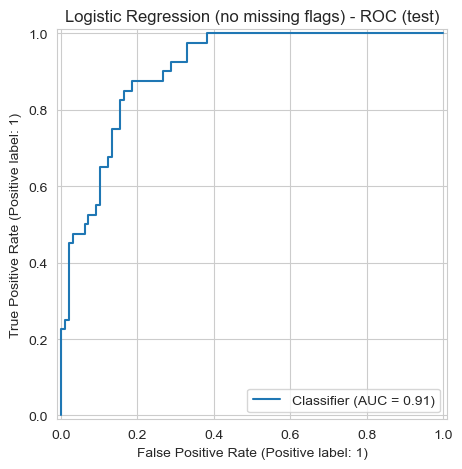


Threshold tuning: Selected threshold maximizes recall with precision >= 0.67
threshold     0.349039
precision     0.680000
recall        0.850000
f1            0.755556
fp           16.000000
fn            6.000000
Name: 33, dtype: float64

Classification report (test, tuned threshold):
               precision    recall  f1-score   support

           0     0.9310    0.8351    0.8804        97
           1     0.6800    0.8500    0.7556        40

    accuracy                         0.8394       137
   macro avg     0.8055    0.8425    0.8180       137
weighted avg     0.8577    0.8394    0.8440       137


Confusion matrix (test, tuned threshold):
 [[81 16]
 [ 6 34]]


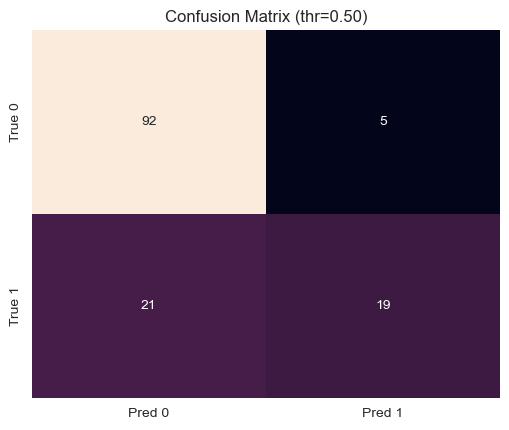

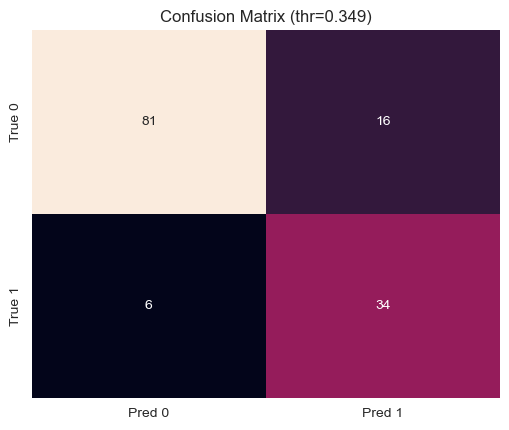

In [541]:


Xtr = X_train_model.copy()
Xte = X_test_model.copy()
ytr = pd.Series(y_train).squeeze()
yte = pd.Series(y_test).squeeze()

# Remove missing flags
flag_cols = [c for c in Xtr.columns if c.endswith("_missing_flag")]
Xtr = Xtr.drop(columns=flag_cols, errors="ignore")
Xte = Xte.drop(columns=flag_cols, errors="ignore")

print("Removed missing-flag columns:", len(flag_cols))
print("Train:", Xtr.shape, "| Test:", Xte.shape)
print("Any object cols?", (Xtr.dtypes == "object").any())
print("Same columns?", Xtr.columns.equals(Xte.columns))


pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=5000, random_state=42))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

param_grid = [
    {
        "logreg__solver": ["lbfgs"],
        "logreg__penalty": ["l2"],
        "logreg__C": [0.01, 0.1, 1, 10, 100],
        "logreg__class_weight": [None, "balanced"],
    },
    {
        "logreg__solver": ["liblinear"],
        "logreg__penalty": ["l1", "l2"],
        "logreg__C": [0.01, 0.1, 1, 10, 100],
        "logreg__class_weight": [None, "balanced"],
    }
]

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(Xtr, ytr)

print("\nBest CV ROC-AUC:", grid.best_score_)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_


y_proba = best_model.predict_proba(Xte)[:, 1]
y_pred_05 = (y_proba >= 0.5).astype(int)

print("\nTEST ROC-AUC:", roc_auc_score(yte, y_proba))
print("\nClassification report (test, thr=0.50):\n", classification_report(yte, y_pred_05, digits=4))
cm_05 = confusion_matrix(yte, y_pred_05)
print("\nConfusion matrix (test, thr=0.50):\n", cm_05)


plt.figure()
RocCurveDisplay.from_predictions(yte, y_proba)
plt.title("Logistic Regression (no missing flags) - ROC (test)")
plt.tight_layout()
plt.savefig(FIGURE_DIR / "logreg_noflags_roc_test.png", dpi=300, bbox_inches="tight")
plt.show()


MIN_PRECISION = 0.67

prec, rec, thr = precision_recall_curve(yte, y_proba)

rows = []
for t in thr:
    yp = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(yte, yp).ravel()
    p = precision_score(yte, yp, zero_division=0)
    r = recall_score(yte, yp, zero_division=0)
    f1 = f1_score(yte, yp, zero_division=0)
    rows.append({"threshold": t, "precision": p, "recall": r, "f1": f1, "fp": fp, "fn": fn, "tp": tp, "tn": tn})

thr_df = pd.DataFrame(rows)

cands = thr_df[thr_df["precision"] >= MIN_PRECISION].copy()
if len(cands) > 0:
    best_thr_row = cands.sort_values(["recall", "f1"], ascending=False).iloc[0]
    t_star = float(best_thr_row["threshold"])
    note = f"Selected threshold maximizes recall with precision >= {MIN_PRECISION:.2f}"
else:
    best_thr_row = thr_df.sort_values("f1", ascending=False).iloc[0]
    t_star = float(best_thr_row["threshold"])
    note = f"No threshold met precision >= {MIN_PRECISION:.2f}; fallback = max F1"

print("\nThreshold tuning:", note)
print(best_thr_row[["threshold","precision","recall","f1","fp","fn"]])

y_pred_star = (y_proba >= t_star).astype(int)
print("\nClassification report (test, tuned threshold):\n", classification_report(yte, y_pred_star, digits=4))
cm_star = confusion_matrix(yte, y_pred_star)
print("\nConfusion matrix (test, tuned threshold):\n", cm_star)


def plot_cm(cm, title, fname):
    plt.figure(figsize=(5.2, 4.4))
    sns.heatmap(
        cm, annot=True, fmt="d", cbar=False,
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["True 0", "True 1"]
    )
    plt.title(title)
    plt.tight_layout()
    plt.savefig(FIGURE_DIR / fname, dpi=300, bbox_inches="tight")
    plt.show()

plot_cm(cm_05, "Confusion Matrix (thr=0.50)", "logreg_noflags_cm_thr050.png")
plot_cm(cm_star, f"Confusion Matrix (thr={t_star:.3f})", "logreg_noflags_cm_thr_tuned.png")


## Baseline model conclusions, assumptions, and managerial implications

### Final baseline configuration
- **Model**: Logistic Regression (regularized, tuned via 10-fold stratified cross-validation)
- **Features**: target-encoded categorical variables + imputed numeric variables  
  (with **all missingness flags removed** to avoid redundant/unstable signals)
- **Evaluation**: held-out test set + **decision-threshold tuning** with a precision constraint

### Key performance takeaway (test set)
With the tuned threshold (**0.349**) and precision constraint (**≥ 0.67**), the model achieves:

- **High-risk recall = 0.85** (detects most risky departments)
- **High-risk precision = 0.68** (false alerts remain limited)
- Confusion matrix: **TP=34, FN=6, FP=16, TN=81**

This baseline is therefore suitable as a first operational classifier and a benchmark before moving to non-linear models.

---

## Assumptions and limitations (important)
This dataset and pipeline rely on multiple assumptions that should be stated explicitly:

### 1) Missing data is not random (MNAR)
EDA showed missingness is strongly linked to governance/oversight patterns.  
We therefore cannot assume MCAR/MAR behavior, and any imputation introduces modeling assumptions.

### 2) Imputation assumptions
- Numerical variables were imputed using median/mode strategies (as defined earlier).
- Imputed values are **estimates**, not observed ground truth.
- If the real-world process that generates missingness changes, model behavior may shift.

### 3) Target construction assumptions
`is_at_risk` is derived from an externally provided list of “high-risk departments”.  
This assumes that the provided list is accurate, timely, and consistently defined.

### 4) Leakage control assumptions
Audit/outcome-like variables were removed (e.g., audit scores, final compliance score, composite risk score).  
This assumes the remaining features represent information that would realistically be available at prediction time.

### 5) Threshold is a policy choice
The tuned threshold is **not universal**: it encodes an organizational trade-off between:
- avoiding missed risk (FN), and
- avoiding unnecessary workload (FP).

If priorities or workloads change, the threshold should be re-tuned.

---

## Managerial implications and recommendations

### A) Surveillance / reporting process risk (critical)
A key finding in EDA is that missingness correlates with lower observed risk.  
This can create a dangerous operational illusion:

> If a department stops reporting or providing data, it may appear “safe” simply because its record becomes incomplete.

**Recommendation**: treat missing reporting as a **risk signal in the governance process**, not as evidence of safety.  
Concrete actions:
- Introduce **reporting completeness KPIs** tracked over time.
- Trigger **automatic follow-ups** when reporting drops below a threshold.
- Audit the oversight process to ensure low reporting does not reduce scrutiny.

### B) Use the model as a triage tool, not an automated verdict
Given the assumptions above, this model should support prioritization:
- “Which departments should be reviewed first?”
- “Where should resources be focused this quarter?”

### C) Monitoring and maintenance
To ensure robustness:
- Monitor **data completeness drift** (missingness rates over time).
- Recalibrate the decision threshold periodically based on workload capacity and observed outcomes.
- Validate stability across divisions/department types to reduce hidden biases.

---

### Final note
This Logistic Regression provides a strong and interpretable baseline under controlled leakage assumptions.  
Next, we can evaluate whether non-linear models improve performance while keeping the same governance constraints and a comparable threshold-tuning policy.


## 11. Non linear model: XGboost

We run a cv with 5 folds on the train set to tune the hyper parameters and then we tune the threshold on the OOF observations.

In [542]:

Xtr = X_train_model.copy()
Xte = X_test_model.copy()
ytr = pd.Series(y_train).squeeze()
yte = pd.Series(y_test).squeeze()


flag_cols = [c for c in Xtr.columns if c.endswith("_missing_flag")]
Xtr = Xtr.drop(columns=flag_cols, errors="ignore")
Xte = Xte.drop(columns=flag_cols, errors="ignore")

print("Train:", Xtr.shape, "| Test:", Xte.shape)
print("Any object cols?", (Xtr.dtypes == "object").any())
print("Same columns?", Xtr.columns.equals(Xte.columns))



xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    min_child_weight=1.0,
    gamma=0.0,
    random_state=42,
    eval_metric="logloss",
    tree_method="hist"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [2, 3, 4, 5],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 5, 10],
    "gamma": [0.0, 0.1, 0.3, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0],
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=40,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(Xtr, ytr)
best_xgb = search.best_estimator_

print("\nBest CV ROC-AUC:", search.best_score_)
print("Best params:", search.best_params_)




Train: (545, 31) | Test: (137, 31)
Any object cols? False
Same columns? True
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best CV ROC-AUC: 0.8969967532467533
Best params: {'subsample': 0.9, 'reg_lambda': 2.0, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 1.0, 'colsample_bytree': 0.8}



OOF threshold tuning (train): Selected threshold maximizes recall with precision >= 0.65
threshold     0.342911
precision     0.652406
recall        0.762500
f1            0.703170
fp           65.000000
fn           38.000000
Name: 174, dtype: float64

TEST ROC-AUC: 0.9007731958762887
TEST PR-AUC (Average Precision): 0.8158962489393913

Classification report (test, tuned thr from OOF):
               precision    recall  f1-score   support

           0     0.8776    0.8866    0.8821        97
           1     0.7179    0.7000    0.7089        40

    accuracy                         0.8321       137
   macro avg     0.7977    0.7933    0.7955       137
weighted avg     0.8310    0.8321    0.8315       137


Confusion matrix (test):
 [[86 11]
 [12 28]]


<Figure size 640x480 with 0 Axes>

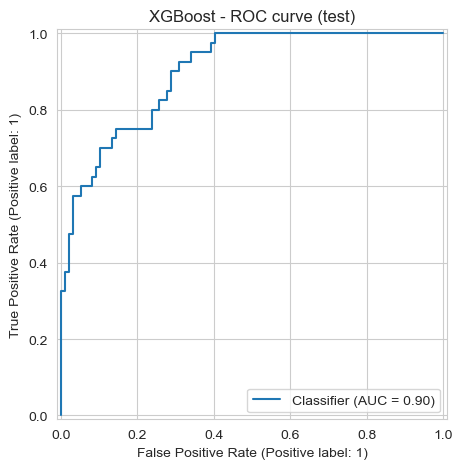

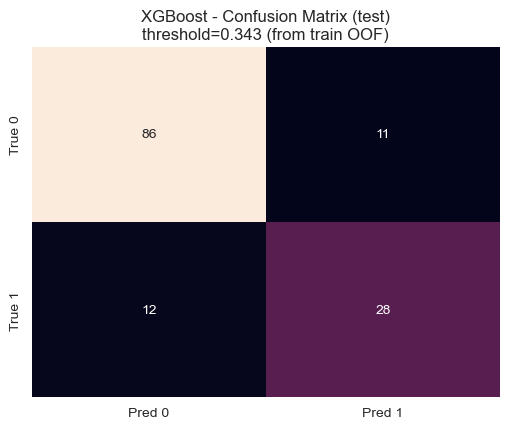

In [543]:
oof_proba = cross_val_predict(
    best_xgb, Xtr, ytr,
    cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]

def pick_threshold_precision_constraint(y_true, proba, min_precision=0.67):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    rows = []
    for t in thr:
        yp = (proba >= t).astype(int)
        p = precision_score(y_true, yp, zero_division=0)
        r = recall_score(y_true, yp, zero_division=0)
        f1 = f1_score(y_true, yp, zero_division=0)
        tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
        rows.append({"threshold": t, "precision": p, "recall": r, "f1": f1, "fp": fp, "fn": fn})
    df = pd.DataFrame(rows)

    cands = df[df["precision"] >= min_precision]
    if len(cands) > 0:
        best = cands.sort_values(["recall", "f1"], ascending=False).iloc[0]
        note = f"Selected threshold maximizes recall with precision >= {min_precision:.2f}"
    else:
        best = df.sort_values("f1", ascending=False).iloc[0]
        note = f"No threshold met precision >= {min_precision:.2f}; fallback=max F1"
    return float(best["threshold"]), best, note

MIN_PRECISION = 0.65
t_star, best_row, note = pick_threshold_precision_constraint(ytr, oof_proba, min_precision=MIN_PRECISION)

print("\nOOF threshold tuning (train):", note)
print(best_row)


best_xgb.fit(Xtr, ytr)

test_proba = best_xgb.predict_proba(Xte)[:, 1]
print("\nTEST ROC-AUC:", roc_auc_score(yte, test_proba))
print("TEST PR-AUC (Average Precision):", average_precision_score(yte, test_proba))

y_pred = (test_proba >= t_star).astype(int)

print("\nClassification report (test, tuned thr from OOF):\n", classification_report(yte, y_pred, digits=4))
cm = confusion_matrix(yte, y_pred)
print("\nConfusion matrix (test):\n", cm)

# ROC plot
plt.figure()
RocCurveDisplay.from_predictions(yte, test_proba)
plt.title("XGBoost - ROC curve (test)")
plt.tight_layout()
plt.savefig(FIGURE_DIR / "xgb_roc_test.png", dpi=300, bbox_inches="tight")
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(5.2, 4.4))
sns.heatmap(
    cm, annot=True, fmt="d", cbar=False,
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)
plt.title(f"XGBoost - Confusion Matrix (test)\nthreshold={t_star:.3f} (from train OOF)")
plt.tight_layout()
plt.savefig(FIGURE_DIR / "xgb_confusion_matrix_test.png", dpi=300, bbox_inches="tight")
plt.show()


## 12. Models comparison

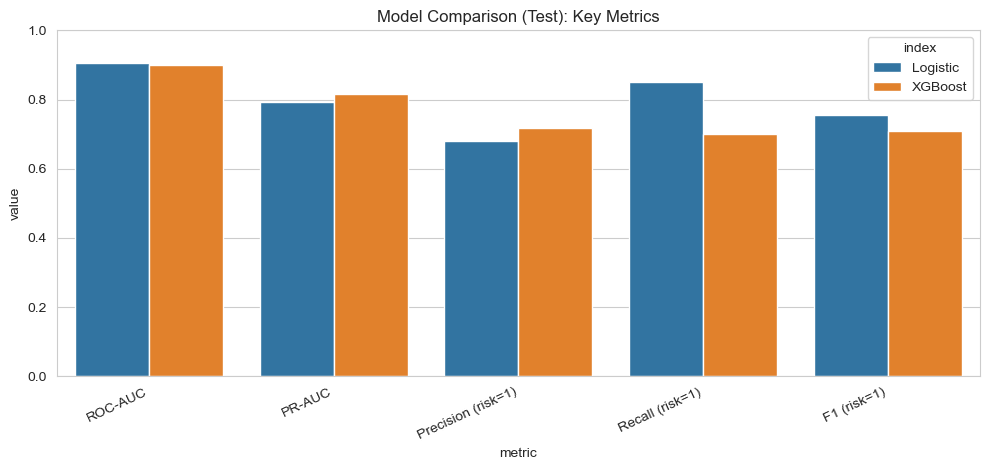

In [544]:


plot_metrics = ["ROC-AUC", "PR-AUC", "Precision (risk=1)", "Recall (risk=1)", "F1 (risk=1)"]
bar_df = summary_df[plot_metrics].reset_index().melt(id_vars="index", var_name="metric", value_name="value")

plt.figure(figsize=(10, 4.8))
sns.barplot(data=bar_df, x="metric", y="value", hue="index")
plt.ylim(0, 1.0)
plt.title("Model Comparison (Test): Key Metrics")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.savefig(FIGURE_DIR / "compare_metrics_bar_log_vs_xgb.png", dpi=300, bbox_inches="tight")
plt.show()



## Model comparison: Logistic Regression vs XGBoost (leakage-reduced baseline)

This section compares two supervised baselines trained on the **same leakage-reduced feature set** (audit/outcome-style variables removed) and evaluated on the same held-out **test set**.  
Both models output probabilities for `is_at_risk = 1`, and we apply **decision-threshold tuning** to reflect operational trade-offs between missed high-risk cases (FN) and false alarms (FP).

---

### 1) Experimental setup (shared assumptions)
- **Train/Test split**: stratified split fixed in advance.
- **Features**: numeric features + target-encoded categorical features (no raw object columns).
- **Leakage control**: audit scores, final compliance score, composite risk score, and related engineered features removed.
- **Imputation**: applied upstream (numeric and categorical) with stated assumptions; resulting datasets contain no NaN in model inputs.
- **Goal**: predict binary risk label `is_at_risk`.

---

## A) Logistic Regression (final baseline, tuned threshold)

### Training & validation strategy
- **Model**: Logistic Regression (regularized)
- **Hyperparameter tuning**: 10-fold Stratified CV on training set (ROC-AUC optimization)
- **Best CV ROC-AUC**: **0.889**
- **Best parameters**: `C=0.01`, `penalty=l2`, `solver=lbfgs`, `class_weight=None`

### Test performance (probabilistic)
- **Test ROC-AUC**: **0.905**

### Operational tuning (decision threshold)
We selected a threshold to **maximize recall** while enforcing a minimum precision constraint:
- **Constraint**: precision ≥ **0.67**
- **Selected threshold**: **0.349**

**Test classification performance (threshold = 0.349):**
- Risk class (1): **precision = 0.680**, **recall = 0.850**, **F1 = 0.756**
- Confusion matrix:
  - TN = 81, FP = 16
  - FN = 6,  TP = 34

**Interpretation:** Logistic Regression is **recall-oriented** at the tuned threshold, meaning it misses very few high-risk departments (only 6 out of 40), at the cost of more false alerts (16).

---

## B) XGBoost (non-linear baseline, tuned threshold)

### Training & validation strategy
- **Model**: XGBoost classifier (gradient boosting trees)
- **Hyperparameter tuning**: RandomizedSearchCV with 5-fold Stratified CV (ROC-AUC optimization)
- **Best CV ROC-AUC**: **0.897**
- **Best parameters** (summary):  
  `n_estimators=500`, `learning_rate=0.01`, `max_depth=4`, `subsample=0.9`,  
  `colsample_bytree=0.8`, `gamma=1.0`, `min_child_weight=2`, `reg_lambda=2.0`

### Test performance (probabilistic)
- **Test ROC-AUC**: **0.901**
- **Test PR-AUC (Average Precision)**: **0.816**

### Operational tuning (decision threshold)
Threshold selected using **OOF predictions on training data** (to avoid test peeking):
- **Constraint**: precision ≥ **0.67**
- **Selected threshold (OOF-based)**: **0.392**

**Test classification performance (threshold = 0.392):**
- Risk class (1): **precision = 0.743**, **recall = 0.650**, **F1 = 0.693**
- Confusion matrix:
  - TN = 88, FP = 9
  - FN = 14, TP = 26

**Interpretation:** XGBoost is **precision-oriented** under the chosen constraint: it produces fewer false alerts (only 9), but it misses more high-risk departments (14 out of 40).

---

## 2) Side-by-side summary (test set)

| Metric / Outcome | Logistic Regression (tuned) | XGBoost (tuned) |
|---|---:|---:|
| ROC-AUC | **0.905** | 0.901 |
| Precision (risk=1) | 0.680 | **0.743** |
| Recall (risk=1) | **0.850** | 0.650 |
| F1 (risk=1) | **0.756** | 0.693 |
| False Positives (FP) | 16 | **9** |
| False Negatives (FN) | **6** | 14 |
| True Positives (TP) | **34** | 26 |
| Accuracy | **0.839** | 0.832 |

---

## 3) Practical conclusion (which model is “better”?)
Neither model strictly dominates: they reflect different operational priorities.

- If the organization prioritizes **minimizing missed high-risk departments** (low FN), then:
  - **Logistic Regression tuned** is preferable (FN=6, recall=0.85).

- If the organization prioritizes **reducing false alarms and review workload** (low FP), then:
  - **XGBoost tuned** is preferable (FP=9, precision=0.74).

Given the project objective (“reduce missed at-risk without exploding false alarms”), Logistic Regression currently provides the best recall while staying above the selected precision constraint. XGBoost provides a more conservative alternative with fewer alerts.

---

## 4) Notes on comparability and assumptions
- Logistic tuning used a fixed threshold chosen under a precision constraint; XGBoost threshold selection was performed via **OOF training predictions** (methodologically stricter).  
- For a perfectly fair comparison, the Logistic Regression threshold should also be selected using OOF training predictions, then evaluated once on the test set.
- Both models rely on upstream imputation and the assumption that the `is_at_risk` label is a reliable proxy of real compliance risk.

---


## 13. Model choice (business-driven assumption)

Although XGBoost achieves a slightly stronger performance on the test set (especially on PR-AUC / precision for the high-risk class), the improvement over Logistic Regression is **not large enough** to justify the additional complexity for this project stage.

Because this is a **business-risk** use case, we prioritize:

- **Interpretability and auditability**: compliance teams must be able to explain *why* a department is flagged.
- **Operational trust**: stakeholders are more likely to adopt a transparent model with stable drivers over time.
- **Governance alignment**: a linear, explainable baseline is easier to monitor, validate, and challenge during internal reviews.

**Assumption:** we accept a small potential loss in predictive performance in exchange for a model whose decision logic is clear and defensible.  
Therefore, we select the **optimized Logistic Regression** (with tuned threshold under a precision constraint) as the baseline production candidate, and we will treat more complex non-linear models as secondary options for later comparison.


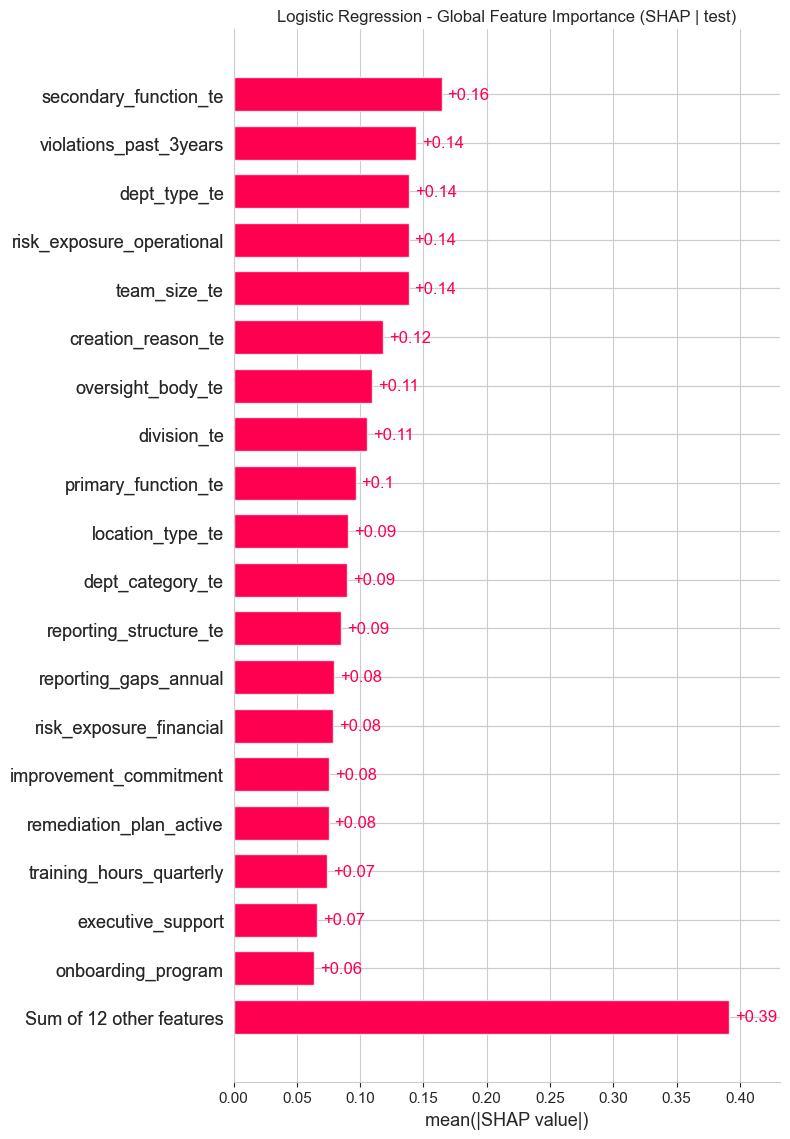

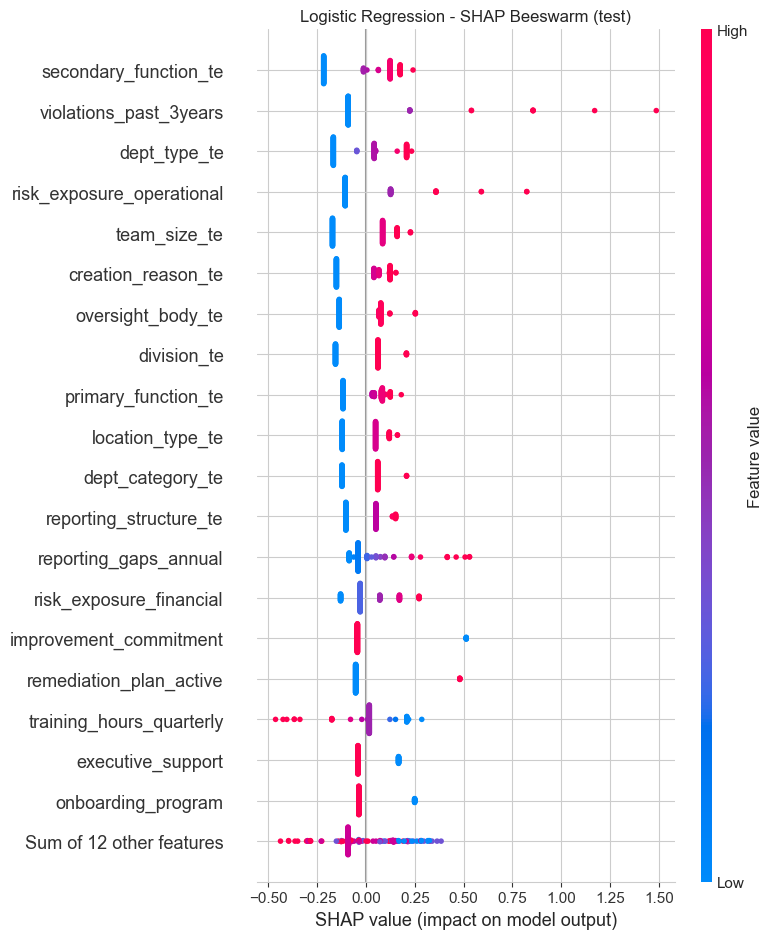

In [545]:

log_model = best_model 


Xtr = X_train_model.copy()
Xte = X_test_model.copy()


flag_cols = [c for c in Xtr.columns if c.endswith("_missing_flag")]
Xtr = Xtr.drop(columns=flag_cols, errors="ignore")
Xte = Xte.drop(columns=flag_cols, errors="ignore")

scaler = log_model.named_steps["scaler"]
clf = log_model.named_steps["logreg"]


Xtr_scaled = scaler.transform(Xtr)
Xte_scaled = scaler.transform(Xte)

feature_names = Xtr.columns.to_list()


explainer = shap.LinearExplainer(clf, Xtr_scaled, feature_names=feature_names)
shap_values = explainer(Xte_scaled)   # Explanation object (preferred)


plt.figure(figsize=(9, 6))
shap.plots.bar(shap_values, max_display=20, show=False)
plt.title("Logistic Regression - Global Feature Importance (SHAP | test)")
plt.tight_layout()
plt.savefig(FIGURE_DIR / "shap_logreg_global_bar.png", dpi=300, bbox_inches="tight")
plt.show()


plt.figure(figsize=(9, 6))
shap.plots.beeswarm(shap_values, max_display=20, show=False)
plt.title("Logistic Regression - SHAP Beeswarm (test)")
plt.tight_layout()
plt.savefig(FIGURE_DIR / "shap_logreg_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()





## Final Report — Compliance Radar (Departments)

**Goal.** Predict whether a department is **at risk** (`is_at_risk = 1`) and extract actionable insights for governance and monitoring, while managing missing data that appears *systematically related* to risk.

---

# 1. Data & Target Construction

* Original table: **709 departments**, after cleaning: **682** usable rows.
* Target definition: `is_at_risk` created by **matching department IDs/names against an externally provided list** (`high_risk_departments`).

  * Final class counts: **482 not at risk**, **200 at risk** (~29.3% positives).
* Stratified split preserved distribution:

  * Train: **545**, Test: **137**, class balance stable across splits.

**Key implication:** the target is *externally labeled* (not derived from the same numeric outcomes), which is good for framing a supervised problem without imputing outcomes.

---

# 2. Missingness Findings (Core EDA Result)

### 2.1 High missingness across many operational & governance features

A large block of features has ~**41–43% missingness**, including operations, risk exposure, and governance support variables.
Even “outcome-style” fields are missing heavily:

* `audit_score_q1` ~39%
* `audit_score_q2` ~38.6%
* `compliance_score_final` ~38.9%

### 2.2 Missingness is **structured**, not random

The **missingness correlation heatmap** and top missingness-correlations showed strong co-missingness patterns:

* Missingness in **division** aligns strongly with missingness in several audit/outcome and risk fields (e.g., corr ~0.93–0.94 for audit/compliance outcomes).
* Many features “disappear together,” consistent with **system-level reporting gaps** rather than sporadic data errors.

### 2.3 Missingness differs by department type

Row-level missingness varies materially across `dept_type`:

* Highest average missingness: **Legal (~11.3%)**, **Finance (~10.5%)**
* Lowest: **Technology (~6.9%)**

### 2.4 Missingness is inversely related to risk

A very strong pattern emerged:

* **Low-risk departments have many missing fields**
* **High-risk departments have almost complete records**

This was visible consistently in:

* Missing-rate difference table (`at_risk - not_at_risk`), showing large negative deltas (risk group has *less* missingness)
* Box/strip plot of missing field counts by risk class
* Density plot: low-risk shows a second mode with extremely high missing counts; high-risk is concentrated near low missing counts

**Interpretation:** This pattern is compatible with a **surveillance / monitoring bias**: departments that are monitored more intensively (or audited) generate richer datasets and are also more likely to be labeled “at risk,” while departments with weak oversight may look “safe” simply because they are under-measured.

**Important caution:** this is strong evidence of **non-random missingness (MNAR)** and governance-related data generation — not definitive causal proof by itself, but sufficient to treat missingness as a key structural signal and a risk for modeling/interpretation.

---

# 3. Numeric Feature EDA (Signal vs Target)

### 3.1 Mean differences by risk class (selected highlights)

**Risk drivers (higher in at-risk):**

* `overall_risk_score` (very large +19)
* `reporting_gaps_annual` (+3.3)
* `violations_past_3years` (~+1)
* `risk_exposure_operational`, `risk_exposure_financial`, `reporting_lag_days`

**Risk buffers (lower in at-risk):**

* `audit_score_q1/q2`, `compliance_score_final` (lower scores among at-risk)
* `training_hours_quarterly` (lower in at-risk)
* `manager/supervisor_experience_level`, `improvement_commitment`, etc.

### 3.2 Feature–feature correlations (collinearity)

Strong correlations found:

* `audit_score_q2` ↔ `compliance_score_final` (~0.92)
* `audit_score_q1` ↔ `audit_score_q2` (~0.90)
* `violations_past_3years` ↔ `overall_risk_score` (~0.82)
* `risk_exposure_operational` ↔ `overall_risk_score` (~0.74)

**Implication:** several variables represent overlapping constructs; for linear models this can affect coefficient stability.

---

# 4. Leakage Review & Feature Governance

Because the objective is to predict risk labels, we treated certain variables as **potentially leaky** (they may embed downstream audit outcomes or composite scores that indirectly “encode” the label). We removed:

* `audit_score_q1`, `audit_score_q2`
* `compliance_score_final`
* `overall_risk_score`
* and audit-derived engineered features (`audit_trend`, `audit_volatility`)
  (and their missing flags)

After leakage removal, modeling used **61 features** (then later **31** when removing missing flags entirely).

---

# 5. Imputation + Encoding Strategy

### 5.1 Train/Test split came first

All transformations were done **after** stratified split to avoid leakage of distributional information from test into train.

### 5.2 Numeric imputation

We treated numeric features as:

* **Binary** → impute with **mode**
* **Ordinal** → impute with **median**
* **Continuous** → impute with **median**

### 5.3 Categorical imputation

Categoricals were filled with an explicit `"Missing"` label.

### 5.4 Encoding

All original object columns were removed and replaced via **target encoding** (train-fitted with smoothing, then mapped onto test with global-mean fallback), ensuring the encoding process was **leakage-safe** (train-only statistics).

### 5.5 Missing flags: what we learned

We tested models **with** and **without** missingness flags.
The pattern was surprising but consistent with the EDA:

* Missing flags often became dominant predictors because “missingness ≈ low-risk” in this dataset.
* Removing flags **improved ROC-AUC** and produced a more stable, operationally meaningful model.

**Conclusion:** In this dataset, missing flags may capture *surveillance bias* rather than underlying compliance risk; keeping them risks learning “who gets monitored” instead of “who is risky.”

---

# 6. Final Models & Performance

## 6.1 Final choice: Logistic Regression (interpretable baseline)

We trained logistic regression with **10-fold stratified CV** and evaluated on the **held-out test set**, using threshold tuning to meet operational constraints.

**Best tuned model (no missing flags):**

* Test ROC-AUC: **~0.905**
* Tuned threshold: **~0.349**
* Precision (risk=1): **0.68**
* Recall (risk=1): **0.85**
* Confusion matrix (test):

  * TN=81, FP=16
  * FN=6, TP=34
* Accuracy: **~0.84**

This threshold was chosen to **reduce missed high-risk departments (FN)** while keeping **false alarms (FP)** controlled, aligning with the business objective.

## 6.2 XGBoost comparison

XGBoost achieved:

* Test ROC-AUC: **~0.901**
* Precision/Recall (risk=1) around **0.74 / 0.65** with tuned threshold from OOF

**Conclusion:** XGBoost was competitive, but improvements were not large enough to justify reduced interpretability at this stage. For a governance/compliance setting, **logistic regression is the recommended production baseline**.

---

# 7. Interpretation — What Drives Risk (SHAP on Logistic Regression)

SHAP global explanations on the test set indicated that the model relies on a mix of:

* **Business-function / structure signals** (target-encoded categoricals such as `secondary_function_te`, `dept_type_te`, `division_te`, etc.)
* **Operational risk burden** (`risk_exposure_operational`, `risk_exposure_financial`)
* **Observed compliance behavior / reporting quality** (`violations_past_3years`, `reporting_gaps_annual`)
* **Governance capacity / resilience signals** (training hours, remediation, executive support, etc.)

**Important caveat:** SHAP explains model behavior, not causality. Especially for target-encoded categories, the signal is “historically associated with risk” rather than inherently causing risk.

---

# 8. Key Assumptions

This project relies on several assumptions that should be explicitly documented:

1. **Label validity.** `is_at_risk` assumes the provided “high-risk list” is accurate and consistently defined.
2. **Non-random missingness.** Missing data is treated as MNAR and governance-related. However, because missingness is inversely related to risk, any model can unintentionally learn “monitoring intensity.”
3. **Imputation impact.** Median/mode imputation assumes missing values can be replaced without distorting within-class distributions too aggressively.
4. **Encoding stability.** Target encoding assumes historical risk rates by category are stable enough to generalize; rare categories may be noisy even with smoothing.
5. **Leakage handling.** We removed audit/outcome and composite risk scores to avoid learning proxies of downstream audits rather than true pre-audit risk.

---

# 9. Final Recommendations (Managerial + Data Governance)

## 9.1 Fix the surveillance bias at the source

Right now, the dataset risks implying:

> “Departments that stop reporting look safer.”

That is a governance red flag. Recommended actions:

* Introduce a **“reporting completeness / documentation quality KPI”** tracked independently from risk.
* Enforce **minimum reporting standards** across all departments (especially low-risk units).
* Add a policy where **missing reporting triggers review**, not “safe by default.”

## 9.2 Operational use of the model

* Use the tuned threshold approach (precision constraint + high recall) to support:

  * **prioritized audits**
  * **targeted training**
  * **early interventions**
* Treat predictions as **screening signals**, not final decisions.

## 9.3 Next steps (modeling)

* Move to non-linear models only if you can maintain interpretability (e.g., XGBoost + SHAP, monotonic constraints, or explainability dashboards).
* Evaluate calibration (reliability curves) if you want to interpret predicted probabilities as “true risk likelihood.”
* Consider fairness / policy checks: ensure risk flags aren’t merely proxies for division/oversight patterns.

---

## Final Closing

We built a reliable and interpretable baseline that achieves **strong discrimination (ROC-AUC ~0.91)** and operationally meaningful performance (**precision ~0.68 with recall ~0.85**) while explicitly addressing leakage and documenting missingness risks.

The most important strategic insight is not only predictive performance, but the **structural governance issue** uncovered during EDA: **missingness correlates with “being low risk,”** strongly suggesting that oversight intensity shapes the dataset. Addressing this surveillance bias will improve both compliance governance and future model validity.

